/tmp/ipython-input-190440060.py:110: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  s = s.fillna(method='ffill').fillna(method='bfill')



Now training baseline with: {'alpha': 0.0, 'beta': 0.0, 'n': 0.0, 'seq_len': 20}
epoch 1: train 0.33959, test 0.23987
epoch 2: train 0.34311, test 0.23137
epoch 3: train 0.33888, test 0.22872
epoch 4: train 0.32776, test 0.23128
epoch 5: train 0.32773, test 0.23289
epoch 6: train 0.33445, test 0.22711
epoch 7: train 0.33279, test 0.23032
epoch 8: train 0.32665, test 0.22767
epoch 9: train 0.33360, test 0.22629
epoch 10: train 0.31532, test 0.22485


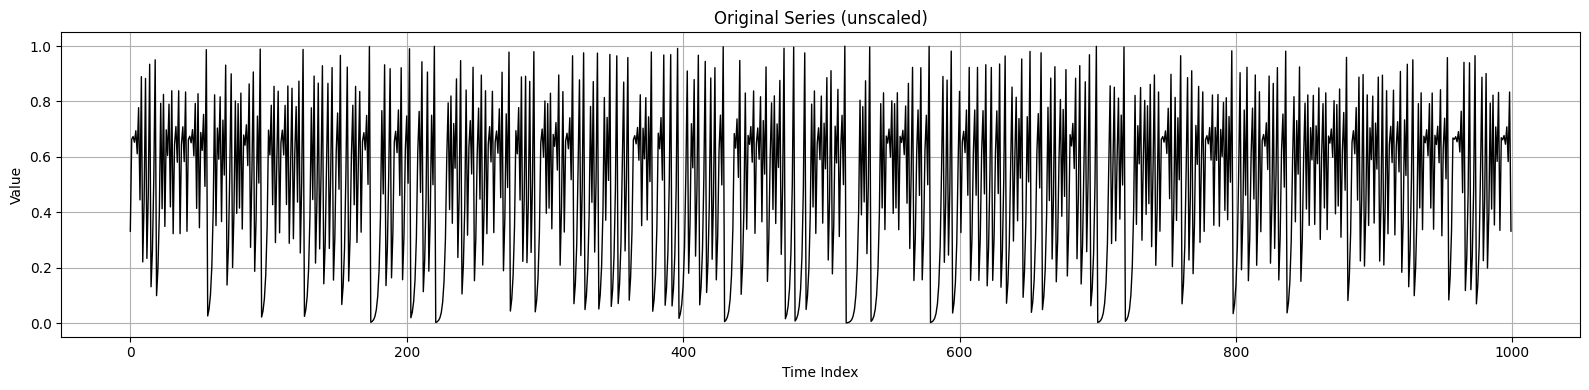

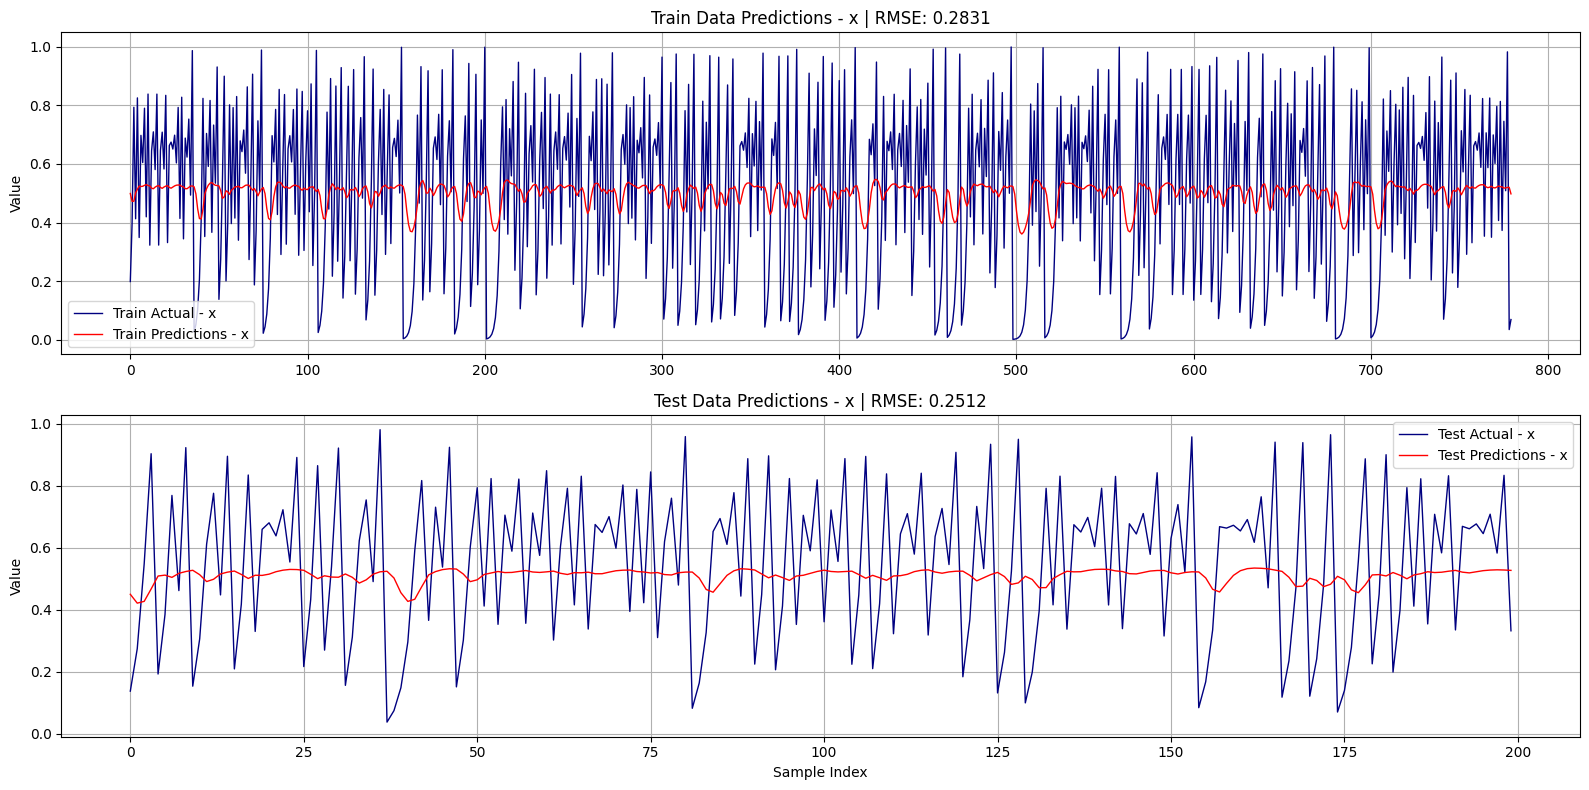

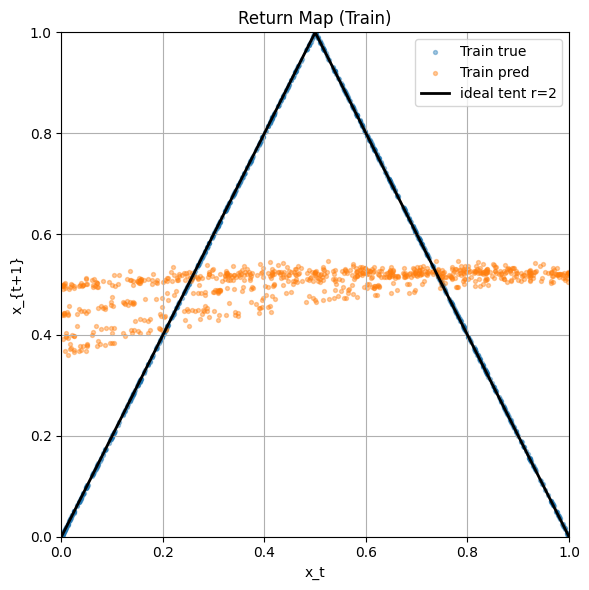

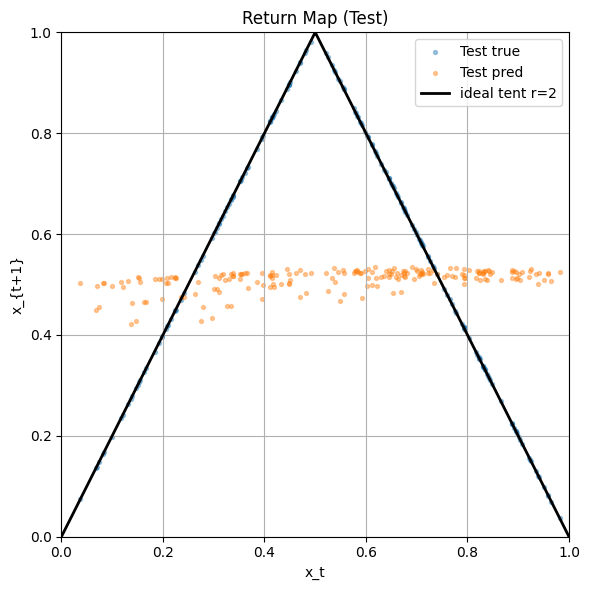

estimated_lyapunov: -0.3460489672400942


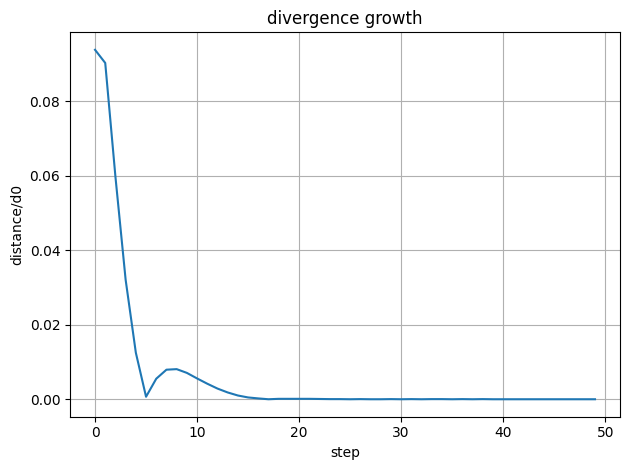


Now training baseline with: {'alpha': 0.0, 'beta': 0.0, 'n': 0.0, 'seq_len': 30}
epoch 1: train 0.34720, test 0.23379
epoch 2: train 0.33361, test 0.23469
epoch 3: train 0.35937, test 0.23292
epoch 4: train 0.35805, test 0.23057
epoch 5: train 0.34752, test 0.23496
epoch 6: train 0.32093, test 0.23380
epoch 7: train 0.33805, test 0.23077
epoch 8: train 0.32986, test 0.23111
epoch 9: train 0.33518, test 0.22757
epoch 10: train 0.31761, test 0.22663


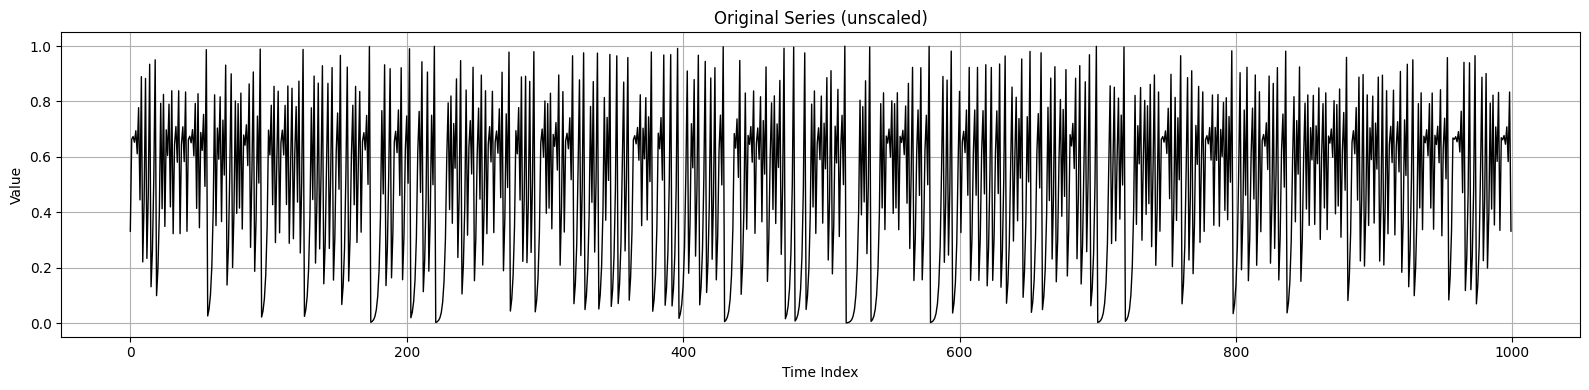

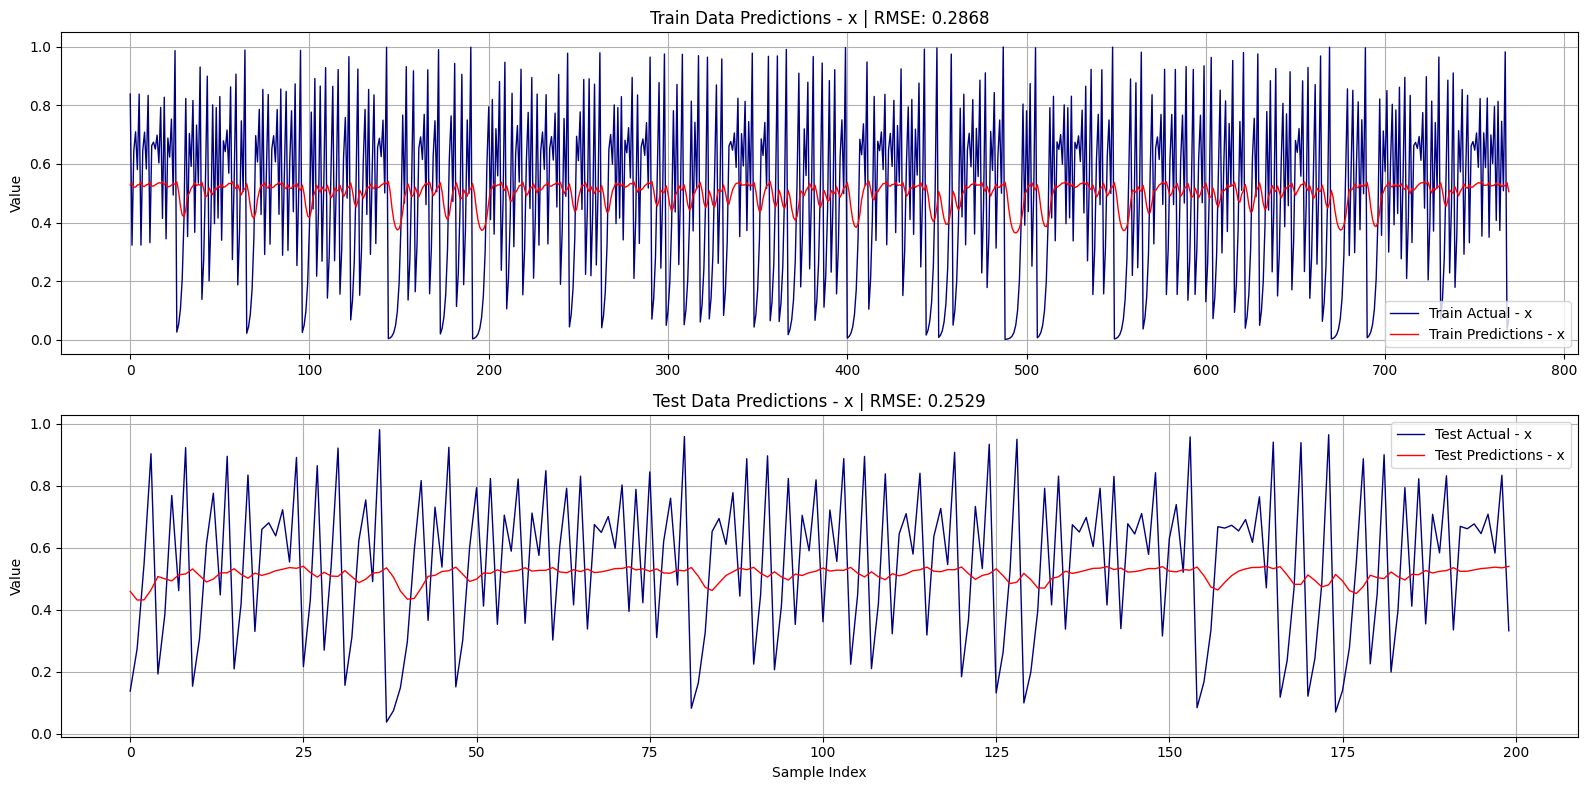

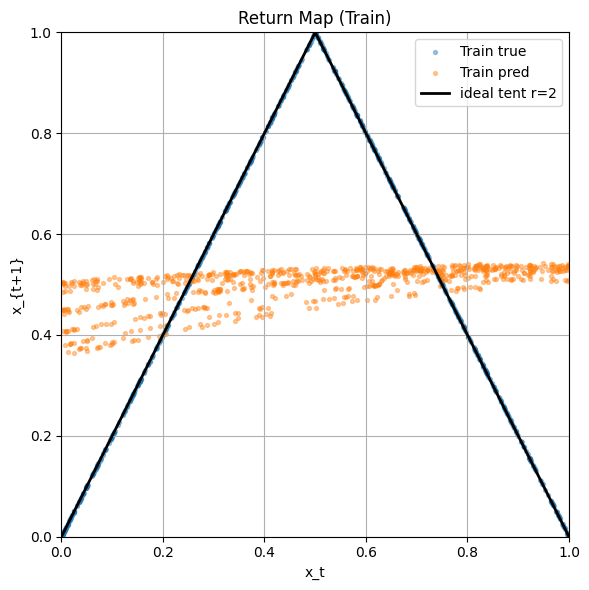

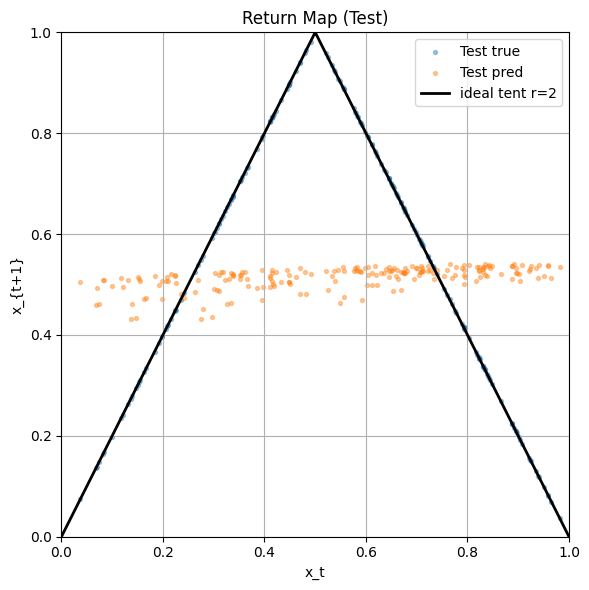

estimated_lyapunov: -0.3576200332962164


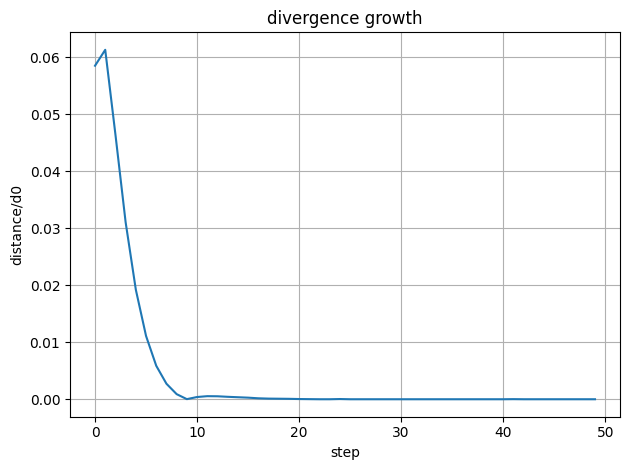


Now training baseline with: {'alpha': 0.0, 'beta': 0.0, 'n': 0.0, 'seq_len': 40}
epoch 1: train 0.35653, test 0.23004
epoch 2: train 0.34866, test 0.24088
epoch 3: train 0.34460, test 0.23696
epoch 4: train 0.34184, test 0.23505
epoch 5: train 0.33920, test 0.23207
epoch 6: train 0.33747, test 0.22988
epoch 7: train 0.33578, test 0.23093
epoch 8: train 0.33467, test 0.23261
epoch 9: train 0.33174, test 0.23224
epoch 10: train 0.33004, test 0.23129


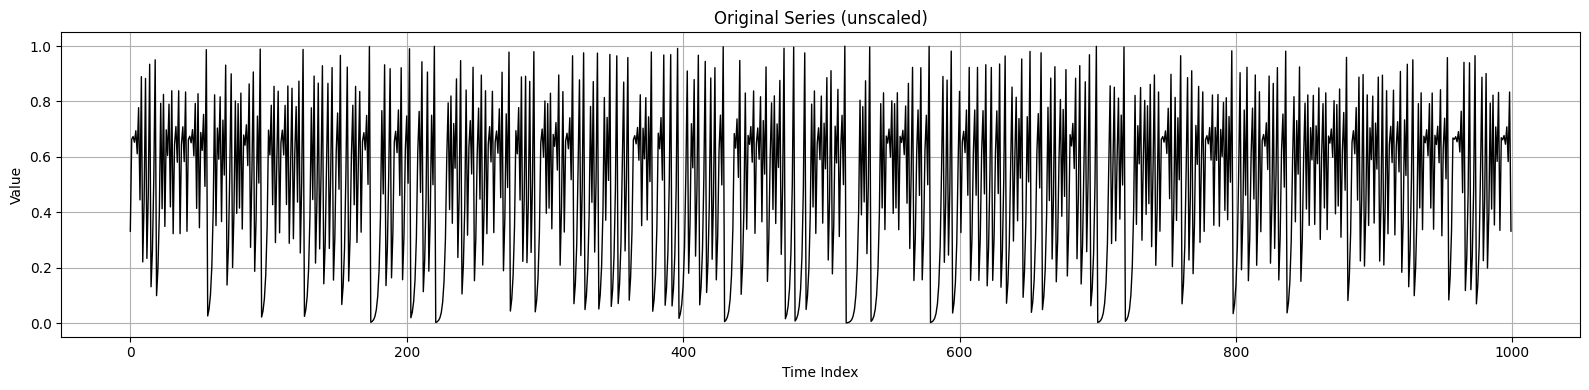

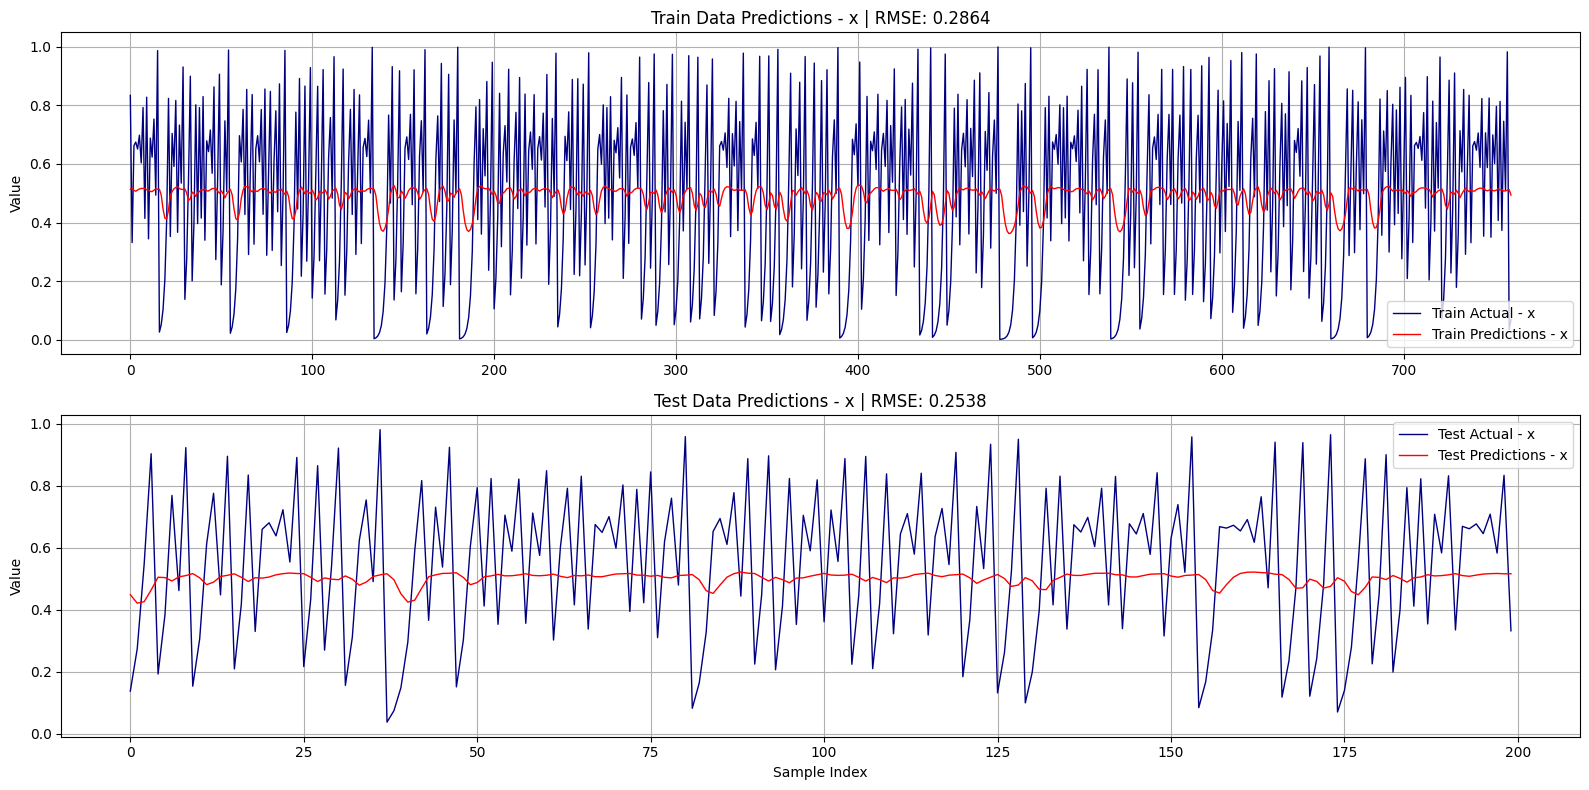

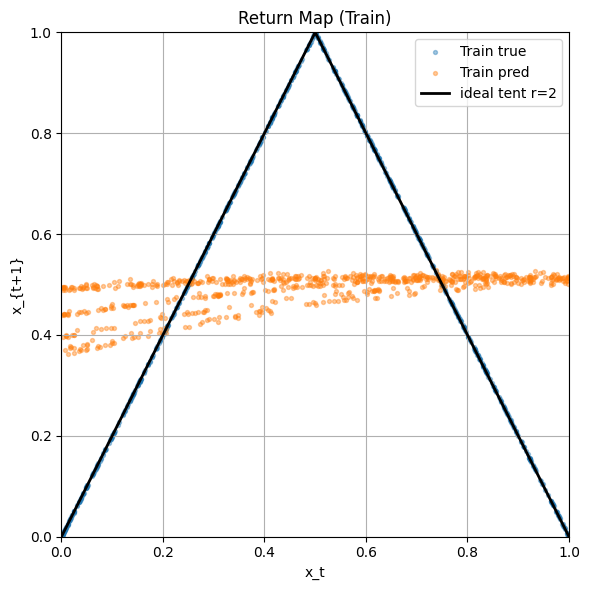

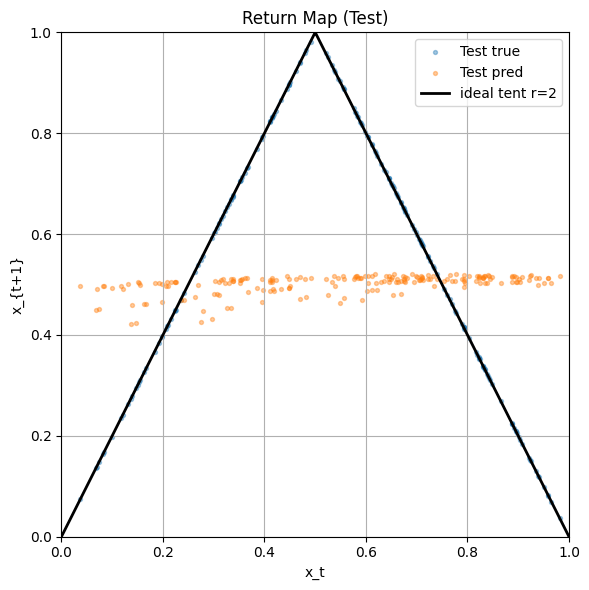

estimated_lyapunov: -0.24058213992994654


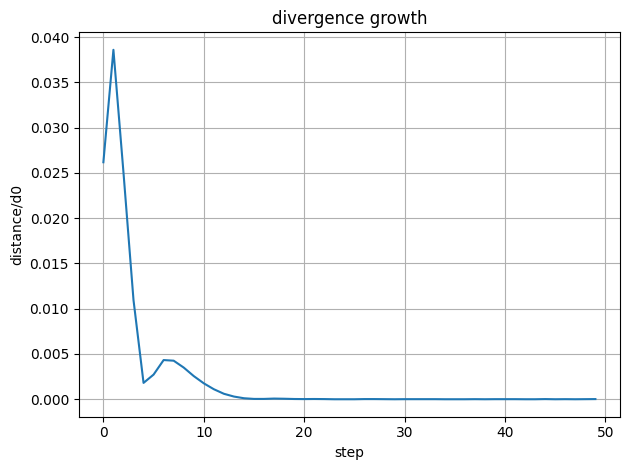


===== BASELINE GRID SEARCH SUMMARY =====
   alpha  beta    n  seq_len  final_train_loss  final_test_loss  train_rmse  \
0    0.0   0.0  0.0       20          0.315318         0.224847    0.283081   
1    0.0   0.0  0.0       30          0.317614         0.226627    0.286839   
2    0.0   0.0  0.0       40          0.330035         0.231290    0.286377   

   test_rmse  lyapunov  
0   0.251234 -0.346049  
1   0.252910 -0.357620  
2   0.253780 -0.240582  


In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



class BaselineSigmoid(nn.Module):
    def forward(self, x):
        return torch.sigmoid(x)

class BaselineTanh(nn.Module):
    def forward(self, x):
        return torch.tanh(x)


class BaselineLSTMCell(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.hidden_size = hidden_size

        # Same parameterization style as your ChebyLSTMCell
        self.w_ih = nn.Parameter(torch.empty(4 * hidden_size, input_size))
        self.w_hh = nn.Parameter(torch.empty(4 * hidden_size, hidden_size))
        self.b_ih = nn.Parameter(torch.zeros(4 * hidden_size))
        self.b_hh = nn.Parameter(torch.zeros(4 * hidden_size))

        # Use plain sigmoid/tanh
        self.sigmoid = BaselineSigmoid()
        self.tanh = BaselineTanh()

        # Xavier init like you did
        init.xavier_uniform_(self.w_ih)
        init.xavier_uniform_(self.w_hh)

    def forward(self, x_t, state):
        h, c = state  # each (batch, hidden_size)

        gates = F.linear(x_t, self.w_ih, self.b_ih) + F.linear(h, self.w_hh, self.b_hh)
        i, f, g, o = gates.chunk(4, dim=1)

        i = self.sigmoid(i)
        f = self.sigmoid(f)
        g = self.tanh(g)
        o = self.sigmoid(o)

        c_next = f * c + i * g
        h_next = o * self.tanh(c_next)

        # match your ChebyLSTMCell return signature
        return h_next, (h_next, c_next)



class BaselineLSTM(nn.Module):
    def __init__(self, hidden_size=32):
        super().__init__()
        self.cell = BaselineLSTMCell(input_size=1, hidden_size=hidden_size)
        self.fc = nn.Linear(hidden_size, 1)

        init.xavier_uniform_(self.fc.weight)
        if self.fc.bias is not None:
            init.constant_(self.fc.bias, 0)

    def forward(self, x):
        # x: (batch, seq_len, 1)
        x = x.transpose(0, 1)  # (seq_len, batch, 1)
        b = x.size(1)

        h = torch.zeros(b, self.cell.hidden_size, device=x.device)
        c = torch.zeros(b, self.cell.hidden_size, device=x.device)

        for t in range(x.size(0)):
            h, (h, c) = self.cell(x[t], (h, c))

        y = self.fc(h)  # final hidden → prediction
        return y  # shape (batch, 1)


def load_series(csv_path, value_column="x"):
    df = pd.read_csv(csv_path)
    if value_column in df.columns:
        s = df[value_column]
    else:
        num_df = df.select_dtypes(include=[np.number])
        if num_df.shape[1] == 0:
            s = pd.to_numeric(df.iloc[:,0], errors='coerce')
        else:
            s = num_df.iloc[:,0]

    s = s.fillna(method='ffill').fillna(method='bfill')
    if s.isnull().any():
        s = s.fillna(s.mean())

    return s.to_numpy().astype(np.float32)

def make_supervised(series, seq_len):
    Xs = []
    Ys = []
    for i in range(len(series) - seq_len):
        Xs.append(series[i:i+seq_len])
        Ys.append(series[i+seq_len])
    X = np.array(Xs).reshape(-1, seq_len, 1)
    Y = np.array(Ys).reshape(-1, 1)
    return X, Y

def prepare_loaders(series, seq_len=20, split=0.8, batch=64):
    N = len(series)
    cut = int(N*split)

    scaler = MinMaxScaler(feature_range=(-1,1))
    scaler.fit(series[:cut].reshape(-1,1))  # fit only on "train time"
    scaled = scaler.transform(series.reshape(-1,1)).reshape(-1)

    X, Y = make_supervised(scaled, seq_len)

    Xtr, Xte = X[:cut-seq_len], X[cut-seq_len:]
    Ytr, Yte = Y[:cut-seq_len], Y[cut-seq_len:]

    Xtr = torch.tensor(Xtr, dtype=torch.float32, device=device)
    Ytr = torch.tensor(Ytr, dtype=torch.float32, device=device)
    Xte = torch.tensor(Xte, dtype=torch.float32, device=device)
    Yte = torch.tensor(Yte, dtype=torch.float32, device=device)

    train_loader = DataLoader(TensorDataset(Xtr, Ytr), batch_size=batch, shuffle=True)
    test_loader  = DataLoader(TensorDataset(Xte, Yte), batch_size=batch, shuffle=False)

    return train_loader, test_loader, scaler, Xtr, Ytr, Xte, Yte


def train_once(model, train_loader, test_loader, epochs=10, lr=1e-3):
    model = model.to(device)
    opt = optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()

    train_losses = []
    test_losses = []

    for ep in range(epochs):
        model.train()
        total = 0.0
        for xb, yb in train_loader:
            opt.zero_grad()
            yhat = model(xb)
            loss = loss_fn(yhat, yb)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
            opt.step()
            total += loss.item()
        avg_tr = total / max(1, len(train_loader))

        model.eval()
        tot_te = 0.0
        with torch.no_grad():
            for xb, yb in test_loader:
                yhat = model(xb)
                tot_te += loss_fn(yhat, yb).item()
        avg_te = tot_te / max(1, len(test_loader))

        train_losses.append(avg_tr)
        test_losses.append(avg_te)

        print(f"epoch {ep+1}: train {avg_tr:.5f}, test {avg_te:.5f}")

    return model, train_losses, test_losses

def inverse_and_rmse(model, X, Y, scaler):
    model.eval()
    with torch.no_grad():
        pred = model(X).cpu().numpy()
    true = Y.cpu().numpy()

    pred_inv = scaler.inverse_transform(pred)
    true_inv = scaler.inverse_transform(true)

    rmse = np.sqrt(np.mean((pred_inv - true_inv) ** 2))

    return true_inv.reshape(-1), pred_inv.reshape(-1), rmse

def full_series_from_scaler(series):
    return series


def plot_train_test_predictions(train_true, train_pred, train_rmse,
                                test_true, test_pred, test_rmse,
                                full_series):
    plt.figure(figsize=(16,4))
    plt.plot(full_series, color='black', linewidth=1)
    plt.title("Original Series (unscaled)")
    plt.xlabel("Time Index")
    plt.ylabel("Value")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    fig, ax = plt.subplots(2,1,figsize=(16,8),sharex=False)

    ax[0].plot(train_true, label='Train Actual - x', color='navy', linewidth=1)
    ax[0].plot(train_pred, label='Train Predictions - x', color='red', linewidth=1)
    ax[0].set_title(f"Train Data Predictions - x | RMSE: {train_rmse:.4f}")
    ax[0].set_ylabel("Value")
    ax[0].grid(True)
    ax[0].legend()

    ax[1].plot(test_true, label='Test Actual - x', color='navy', linewidth=1)
    ax[1].plot(test_pred, label='Test Predictions - x', color='red', linewidth=1)
    ax[1].set_title(f"Test Data Predictions - x | RMSE: {test_rmse:.4f}")
    ax[1].set_xlabel("Sample Index")
    ax[1].set_ylabel("Value")
    ax[1].grid(True)
    ax[1].legend()

    plt.tight_layout()
    plt.show()

def plot_return_map(x_last_train,
                    y_train_true, y_train_pred,
                    x_last_test,
                    y_test_true, y_test_pred):
    xx = np.linspace(0,1,500)
    tent = np.where(xx < 0.5, 2*xx, 2*(1-xx))

    plt.figure(figsize=(6,6))
    plt.scatter(x_last_train, y_train_true, s=8, alpha=0.4,
                label="Train true", color="tab:blue")
    plt.scatter(x_last_train, y_train_pred, s=8, alpha=0.4,
                label="Train pred", color="tab:orange")
    plt.plot(xx, tent, 'k-', lw=2, label="ideal tent r=2")
    plt.xlim(0,1); plt.ylim(0,1)
    plt.xlabel("x_t"); plt.ylabel("x_{t+1}")
    plt.title("Return Map (Train)")
    plt.grid(True); plt.legend(); plt.tight_layout()
    plt.show()

    plt.figure(figsize=(6,6))
    plt.scatter(x_last_test, y_test_true, s=8, alpha=0.4,
                label="Test true", color="tab:blue")
    plt.scatter(x_last_test, y_test_pred, s=8, alpha=0.4,
                label="Test pred", color="tab:orange")
    plt.plot(xx, tent, 'k-', lw=2, label="ideal tent r=2")
    plt.xlim(0,1); plt.ylim(0,1)
    plt.xlabel("x_t"); plt.ylabel("x_{t+1}")
    plt.title("Return Map (Test)")
    plt.grid(True); plt.legend(); plt.tight_layout()
    plt.show()



def lyapunov_estimate(model, series, scaler,
                      seq_len=20, steps=50, eps=1e-4):
    model.eval()

    scaled_series = scaler.transform(series.reshape(-1,1)).reshape(-1)

    a = scaled_series[:seq_len].copy()
    b = scaled_series[:seq_len].copy()
    b[-1] += eps

    d0 = np.abs(b[-1] - a[-1])
    dists = []

    for _ in range(steps):
        A = torch.tensor(a.reshape(1,seq_len,1),
                         dtype=torch.float32,
                         device=device)
        B = torch.tensor(b.reshape(1,seq_len,1),
                         dtype=torch.float32,
                         device=device)

        with torch.no_grad():
            next_a = model(A).cpu().numpy().reshape(())
            next_b = model(B).cpu().numpy().reshape(())

        d = np.abs(next_b - next_a)
        dists.append(max(d,1e-12) / d0)

        a = np.concatenate([a[1:], [next_a]])
        b = np.concatenate([b[1:], [next_b]])

    logd = np.log(dists)
    t = np.arange(len(logd))

    num = np.sum((t - t.mean()) * (logd - logd.mean()))
    den = np.sum((t - t.mean())**2) + 1e-12
    slope = num / den

    return slope, dists


if __name__ == "__main__":
    csv_path = "tent_long.csv"
    if not os.path.exists(csv_path):
        print("csv not found, put tent_long.csv next to this script")
        raise SystemExit(1)

    raw_series = load_series(csv_path, value_column="x")

    # For fairness with your Cheby code: we still sweep seq_len
    # But alpha/beta/n don't exist here, so we just store dummies.
    hyperparameter_sets = [
        {'alpha': 0.0, 'beta': 0.0, 'n': 0.0, 'seq_len': 20},
        {'alpha': 0.0, 'beta': 0.0, 'n': 0.0, 'seq_len': 30},
        {'alpha': 0.0, 'beta': 0.0, 'n': 0.0, 'seq_len': 40},
    ]

    summary_rows = []

    for hp in hyperparameter_sets:
        print("\n============================================")
        print("Now training baseline with:", hp)

        seq_len = hp['seq_len']

        train_loader, test_loader, scaler, Xtr, Ytr, Xte, Yte = prepare_loaders(
            raw_series,
            seq_len=seq_len,
            split=0.8,
            batch=64
        )

        model = BaselineLSTM(hidden_size=32)

        model, train_losses, test_losses = train_once(
            model,
            train_loader,
            test_loader,
            epochs=10,
            lr=1e-3
        )

        train_true, train_pred, train_rmse = inverse_and_rmse(
            model, Xtr, Ytr, scaler
        )
        test_true,  test_pred,  test_rmse  = inverse_and_rmse(
            model, Xte, Yte, scaler
        )

        full_series = full_series_from_scaler(raw_series)

        x_last_train_scaled = Xtr[:,-1,:].detach().cpu().numpy()
        x_last_test_scaled  = Xte[:,-1,:].detach().cpu().numpy()
        x_last_train = scaler.inverse_transform(x_last_train_scaled).reshape(-1)
        x_last_test  = scaler.inverse_transform(x_last_test_scaled).reshape(-1)

        plot_train_test_predictions(
            train_true,
            train_pred,
            train_rmse,
            test_true,
            test_pred,
            test_rmse,
            full_series
        )

        plot_return_map(
            x_last_train,
            train_true,
            train_pred,
            x_last_test,
            test_true,
            test_pred
        )

        lyap, dist_curve = lyapunov_estimate(
            model,
            raw_series,
            scaler,
            seq_len=seq_len,
            steps=50,
            eps=1e-4
        )

        print("estimated_lyapunov:", lyap)

        plt.figure()
        plt.plot(dist_curve)
        plt.xlabel("step")
        plt.ylabel("distance/d0")
        plt.title("divergence growth")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        summary_rows.append({
            'alpha': hp['alpha'],   # stays 0.0 here, just to align columns
            'beta': hp['beta'],
            'n': hp['n'],
            'seq_len': seq_len,
            'final_train_loss': train_losses[-1],
            'final_test_loss': test_losses[-1],
            'train_rmse': train_rmse,
            'test_rmse': test_rmse,
            'lyapunov': lyap
        })

    print("\n===== BASELINE GRID SEARCH SUMMARY =====")
    df_summary = pd.DataFrame(summary_rows)
    print(df_summary)


/tmp/ipython-input-1468121882.py:92: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  s = s.fillna(method='ffill').fillna(method='bfill')



Now training with: {'alpha': 0.4, 'beta': 0.6, 'n': 1.0, 'seq_len': 20}
epoch 1: train 0.34152, test 0.23855
epoch 2: train 0.33890, test 0.23959
epoch 3: train 0.32872, test 0.23216
epoch 4: train 0.31722, test 0.22857
epoch 5: train 0.32756, test 0.22735
epoch 6: train 0.30953, test 0.22454
epoch 7: train 0.31341, test 0.21959
epoch 8: train 0.31161, test 0.21371
epoch 9: train 0.30889, test 0.21269
epoch 10: train 0.28867, test 0.20279


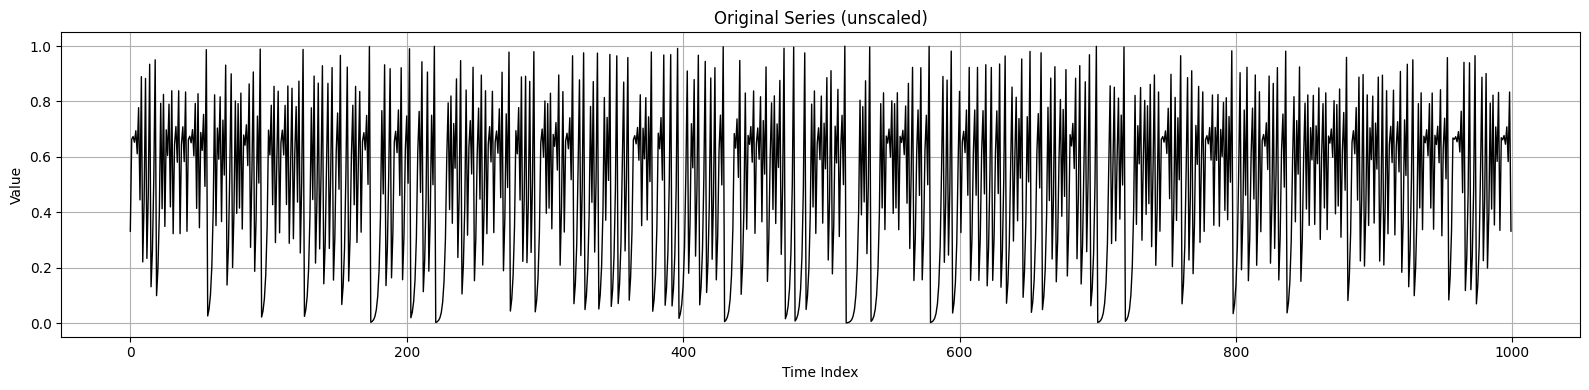

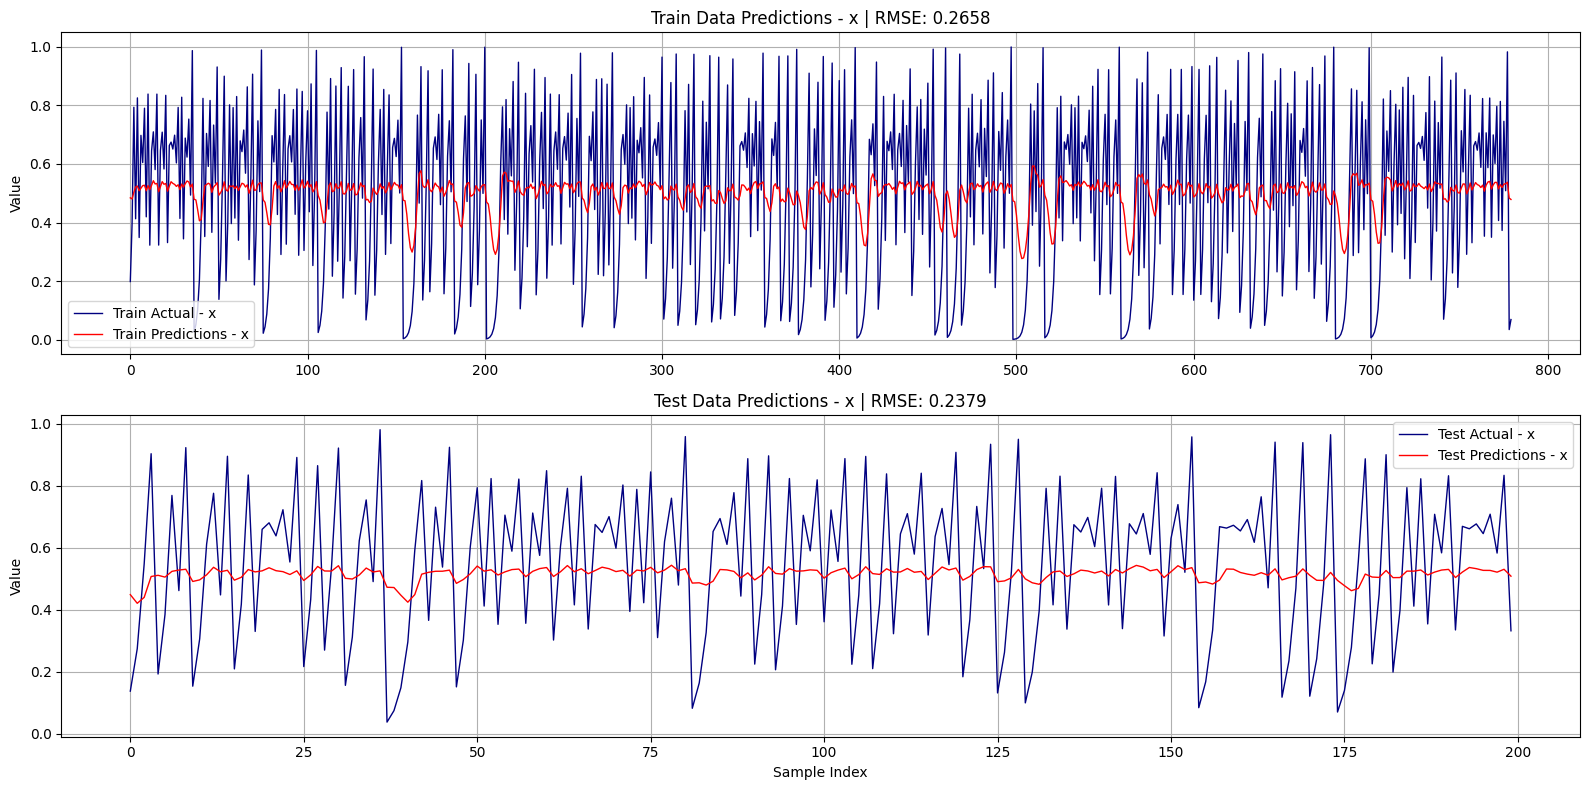

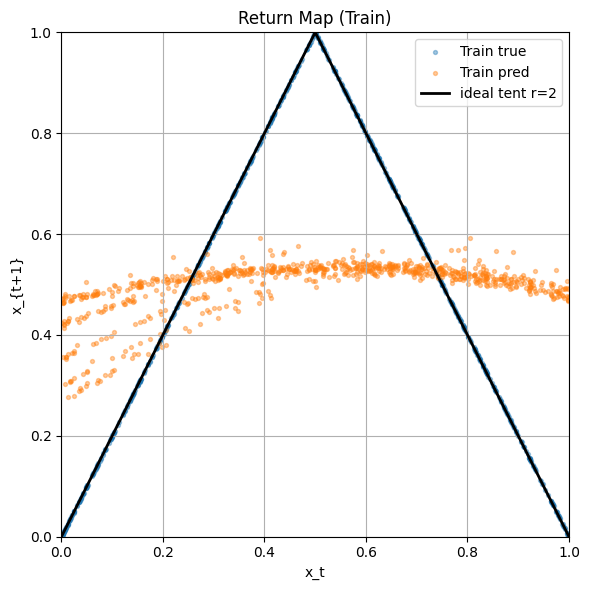

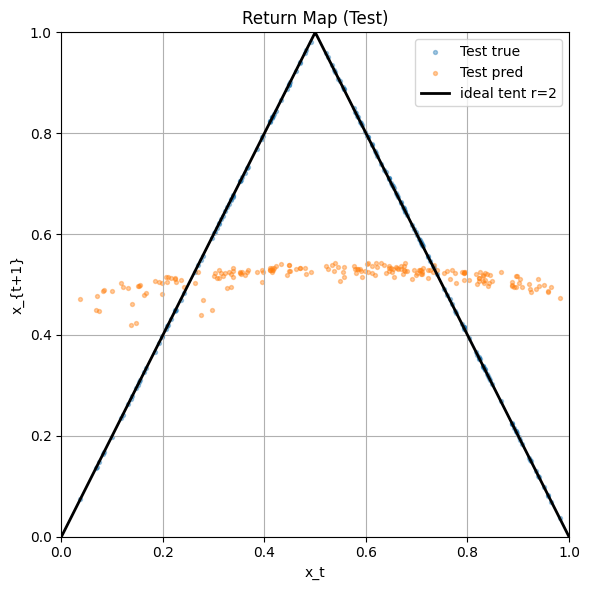

estimated_lyapunov: -0.19723436749425108


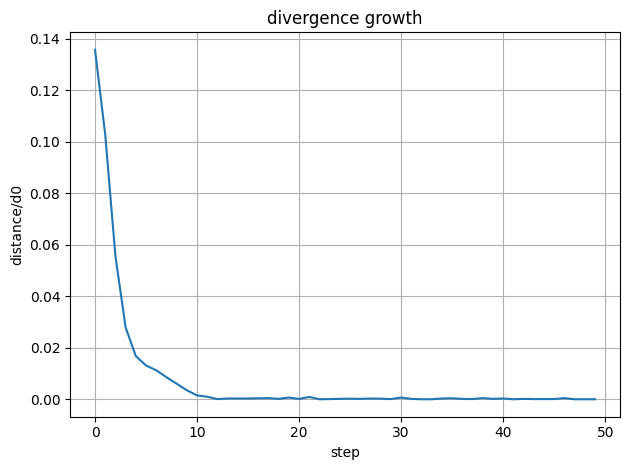


Now training with: {'alpha': -0.3, 'beta': 1.3, 'n': 1.0, 'seq_len': 20}
epoch 1: train 0.34721, test 0.23565
epoch 2: train 0.33439, test 0.23834
epoch 3: train 0.33526, test 0.23811
epoch 4: train 0.33169, test 0.23857
epoch 5: train 0.33780, test 0.23483
epoch 6: train 0.34443, test 0.23586
epoch 7: train 0.33433, test 0.23346
epoch 8: train 0.33866, test 0.23673
epoch 9: train 0.33267, test 0.23521
epoch 10: train 0.33080, test 0.23448


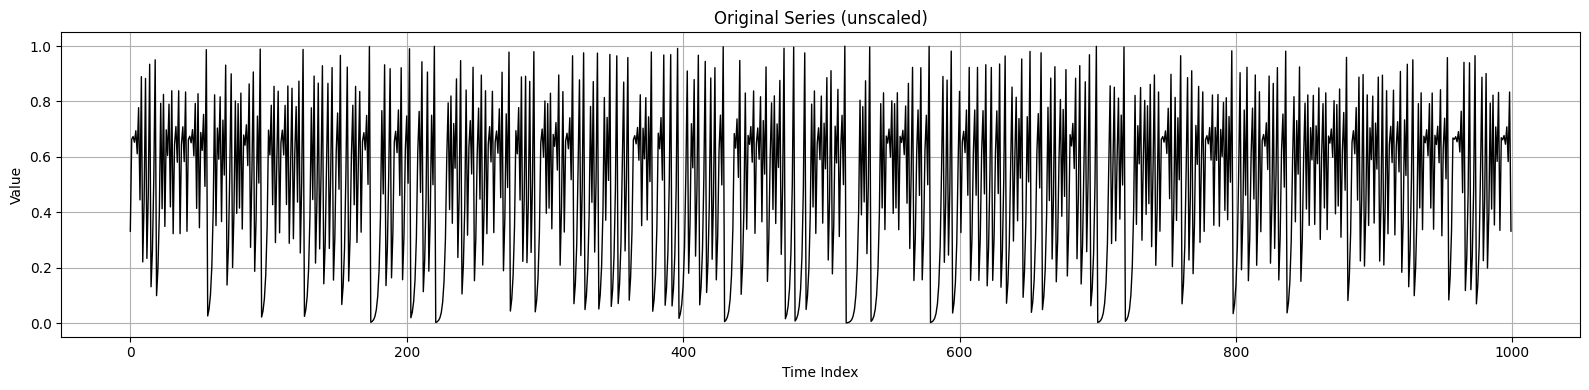

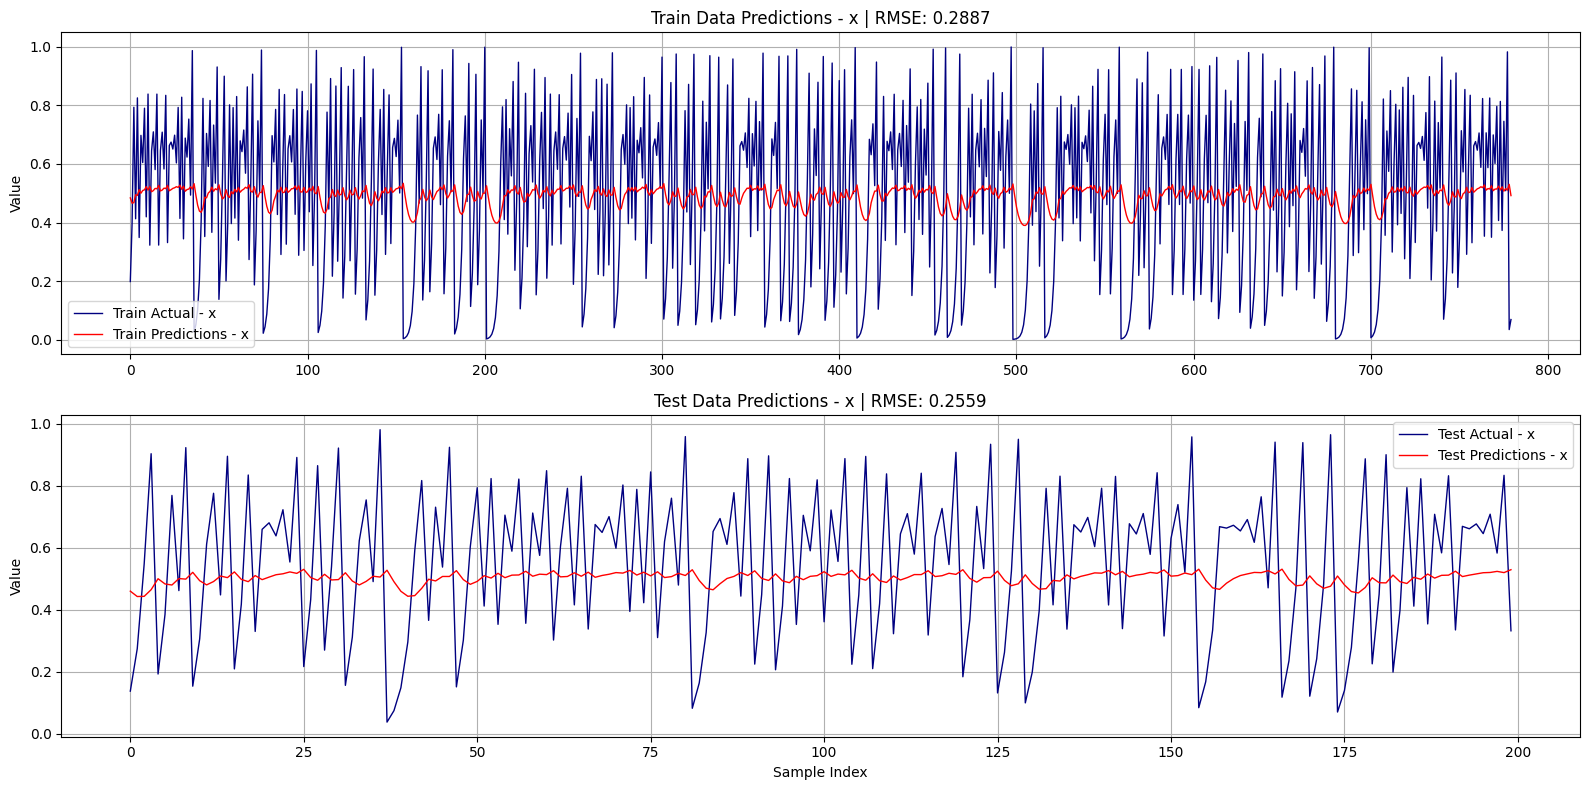

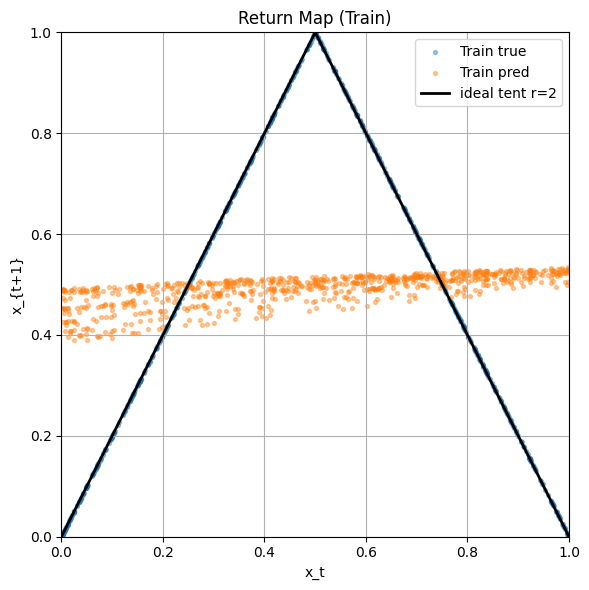

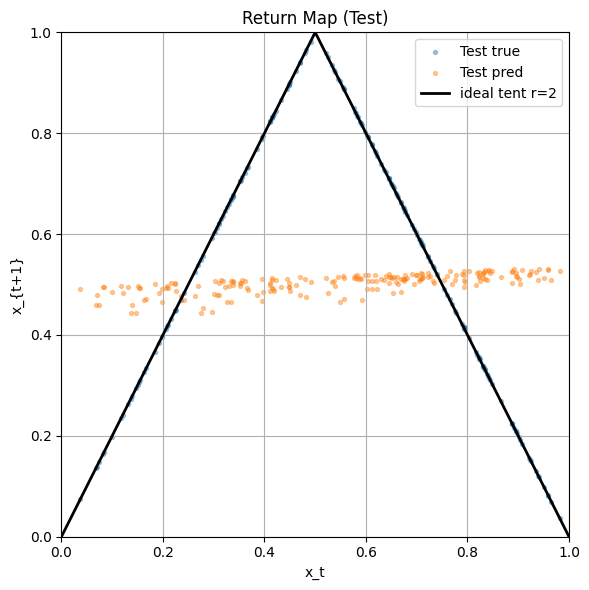

estimated_lyapunov: -0.26373569190859936


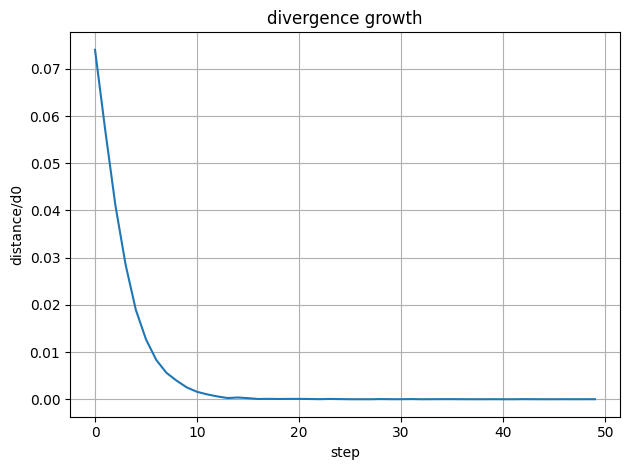


Now training with: {'alpha': -0.5, 'beta': 0.8, 'n': 2.0, 'seq_len': 30}
epoch 1: train 0.37534, test 0.24170
epoch 2: train 0.37346, test 0.22412
epoch 3: train 0.33721, test 0.22429
epoch 4: train 0.31413, test 0.22053
epoch 5: train 0.33303, test 0.22549
epoch 6: train 0.33921, test 0.21264
epoch 7: train 0.29706, test 0.27152
epoch 8: train 0.33617, test 0.21460
epoch 9: train 0.32804, test 0.20820
epoch 10: train 0.31931, test 0.21062


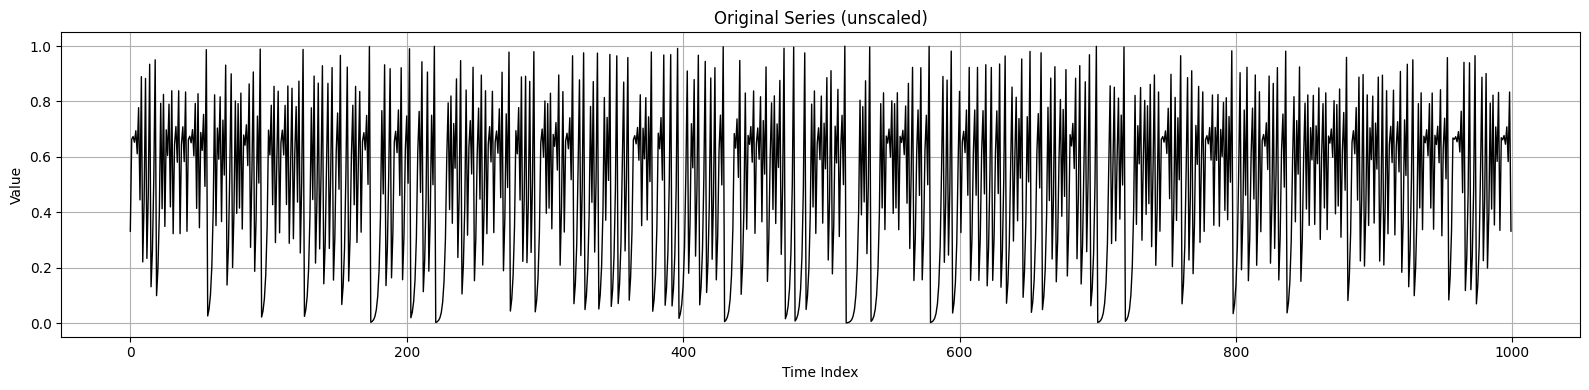

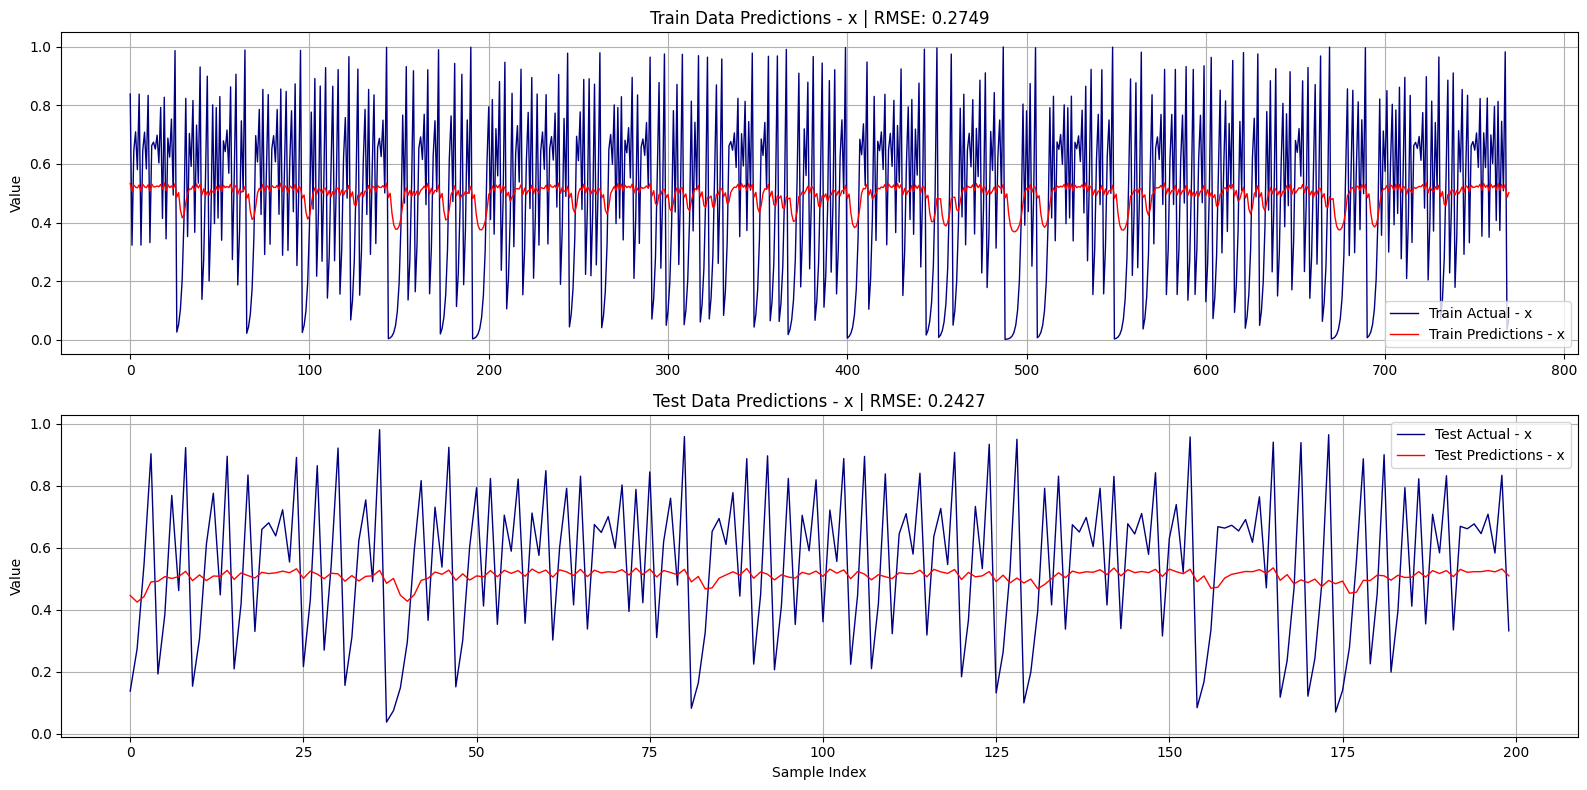

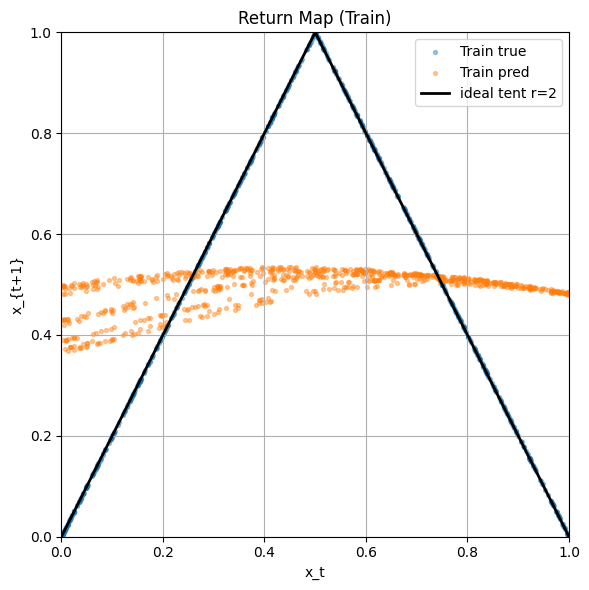

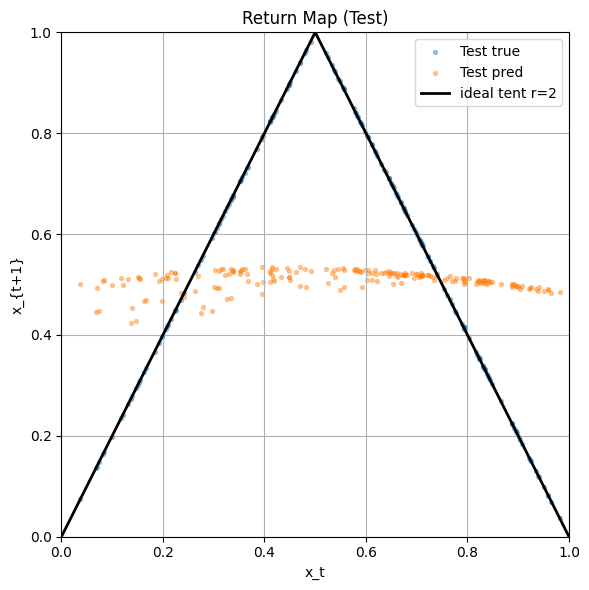

estimated_lyapunov: -0.05053671549491378


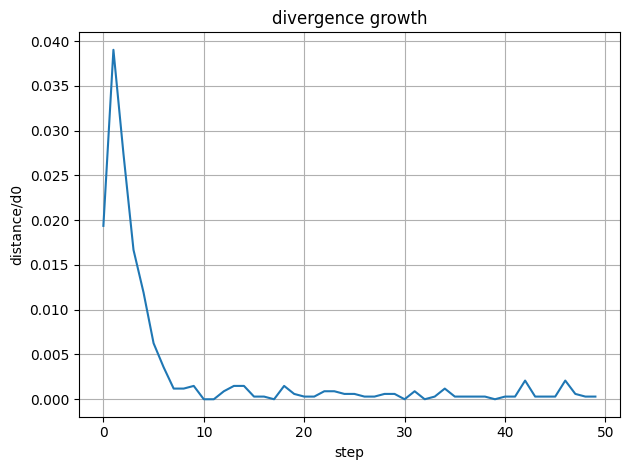


Now training with: {'alpha': 0.6, 'beta': 0.4, 'n': 2.0, 'seq_len': 30}
epoch 1: train 0.38634, test 0.28105
epoch 2: train 0.35203, test 0.24463
epoch 3: train 0.32887, test 0.23594
epoch 4: train 0.33501, test 0.24104
epoch 5: train 0.35592, test 0.23005
epoch 6: train 0.32096, test 0.24354
epoch 7: train 0.32192, test 0.23282
epoch 8: train 0.35430, test 0.23833
epoch 9: train 0.31367, test 0.22379
epoch 10: train 0.32211, test 0.22893


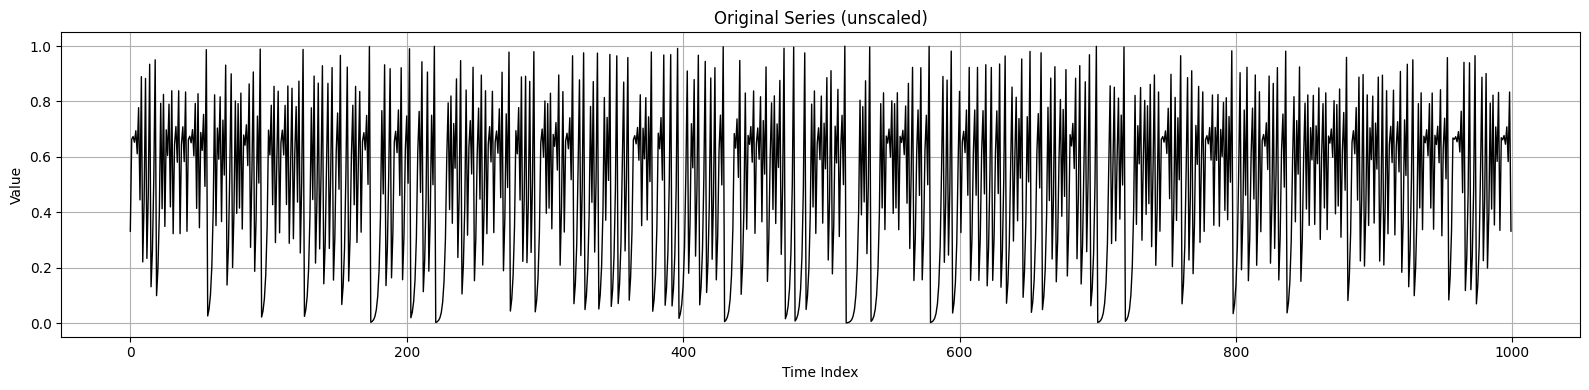

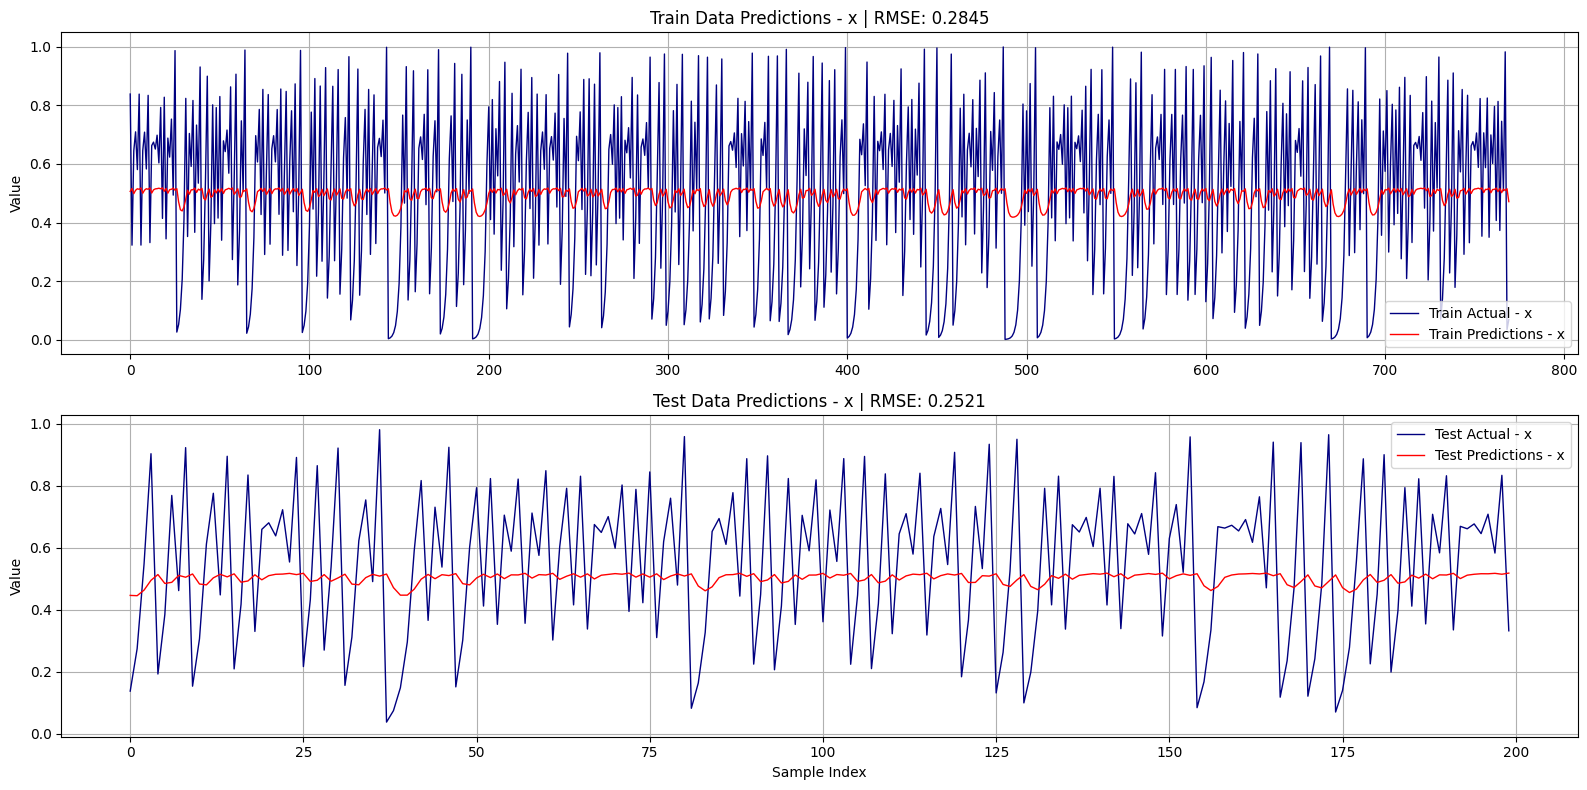

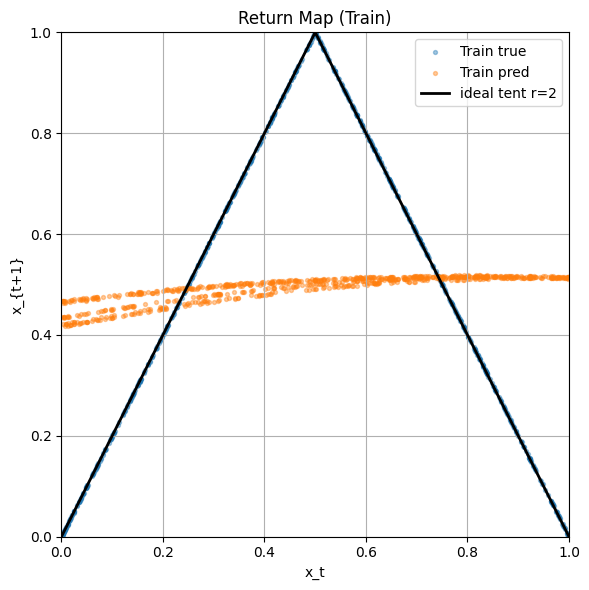

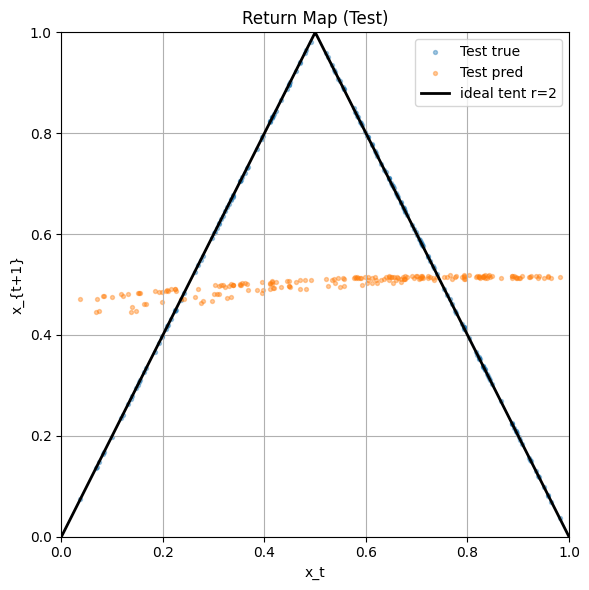

estimated_lyapunov: -0.26990890099936454


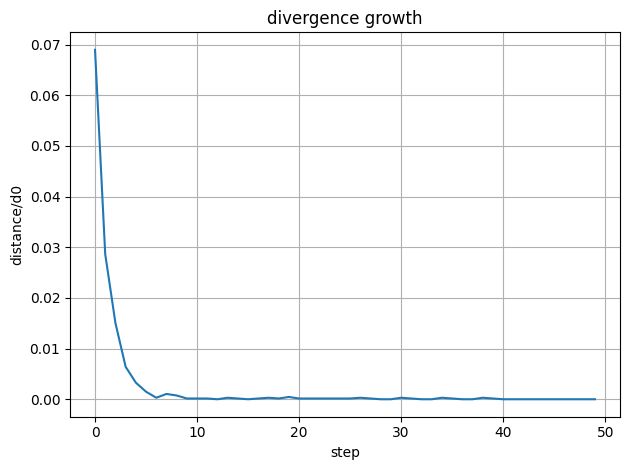


Now training with: {'alpha': -0.2, 'beta': 0.9, 'n': 3.0, 'seq_len': 40}
epoch 1: train 0.35653, test 0.25019
epoch 2: train 0.34597, test 0.23363
epoch 3: train 0.34120, test 0.22926
epoch 4: train 0.33646, test 0.24299
epoch 5: train 0.32806, test 0.22396
epoch 6: train 0.32174, test 0.23543
epoch 7: train 0.31357, test 0.21847
epoch 8: train 0.30464, test 0.20695
epoch 9: train 0.29505, test 0.22149
epoch 10: train 0.28011, test 0.19503


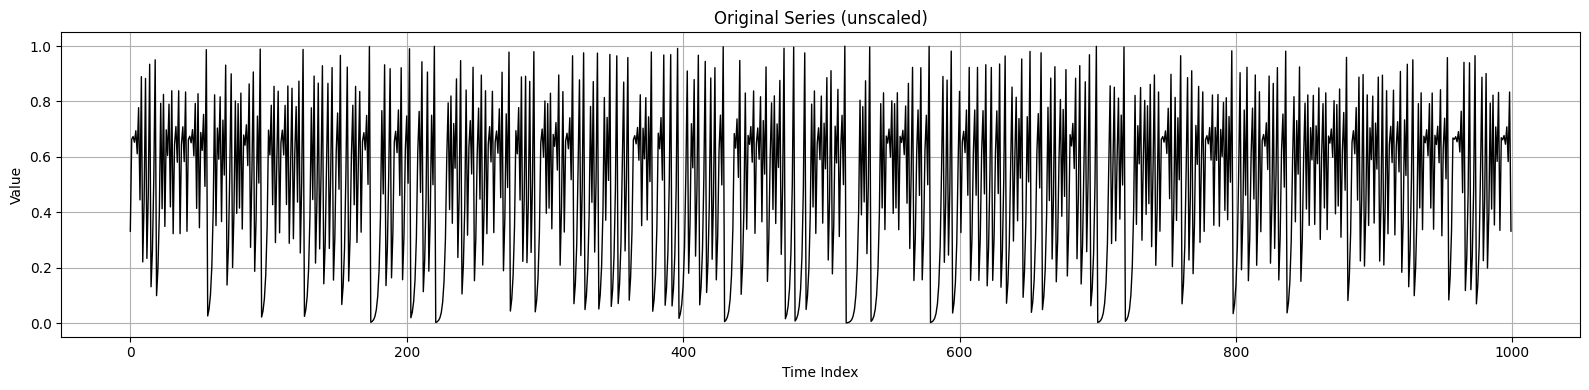

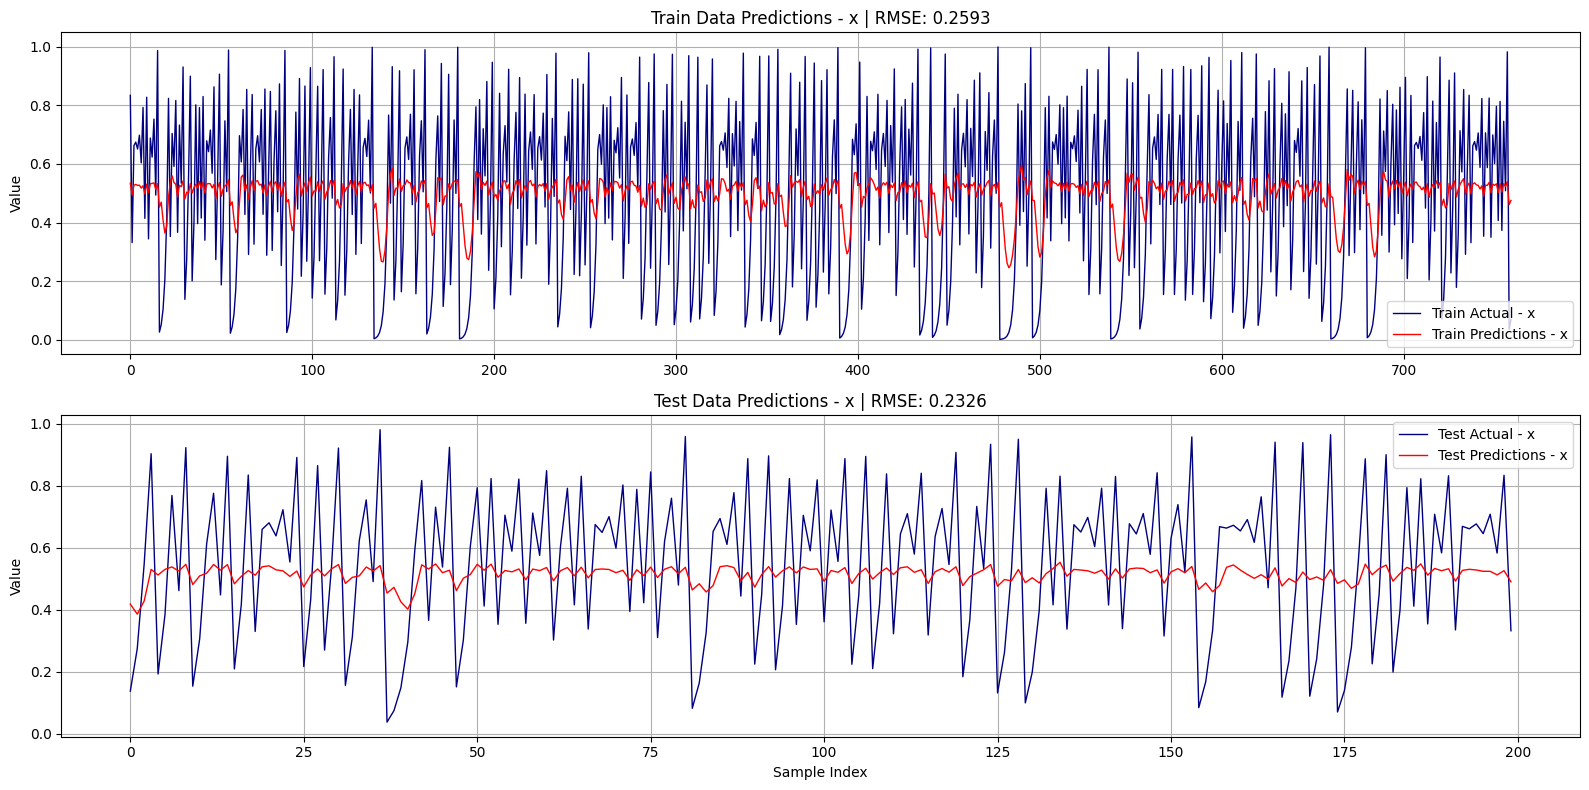

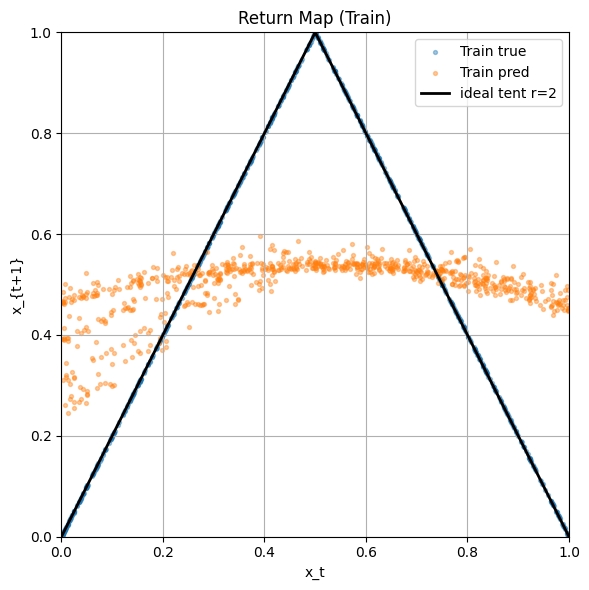

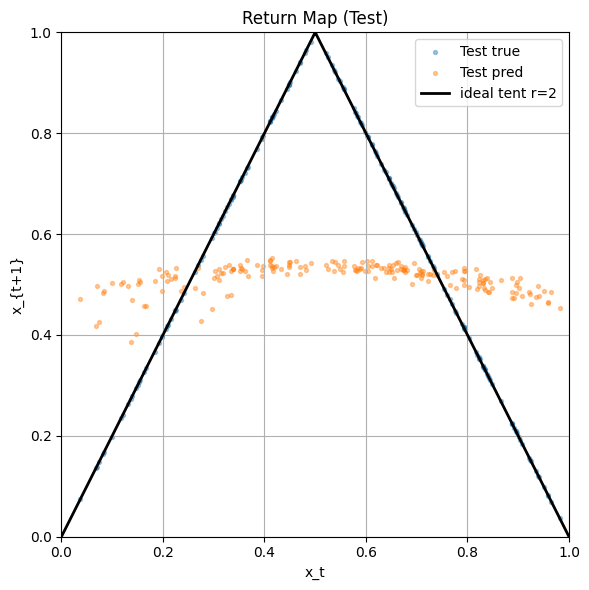

estimated_lyapunov: -0.10635798569916245


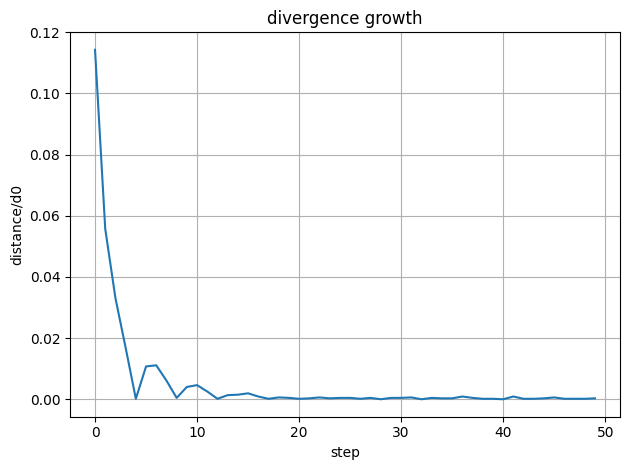


Now training with: {'alpha': 0.7, 'beta': 0.7, 'n': 3.0, 'seq_len': 40}
epoch 1: train 0.34636, test 0.23426
epoch 2: train 0.34484, test 0.23402
epoch 3: train 0.34448, test 0.23268
epoch 4: train 0.34318, test 0.23212
epoch 5: train 0.34104, test 0.23057
epoch 6: train 0.33995, test 0.22892
epoch 7: train 0.33715, test 0.22752
epoch 8: train 0.33427, test 0.22539
epoch 9: train 0.33061, test 0.22200
epoch 10: train 0.32563, test 0.21890


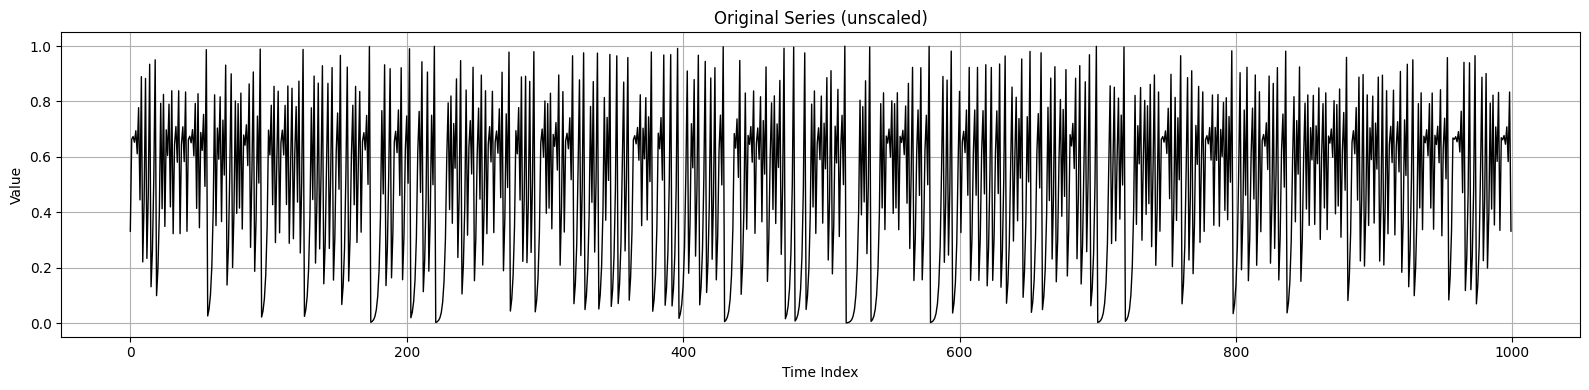

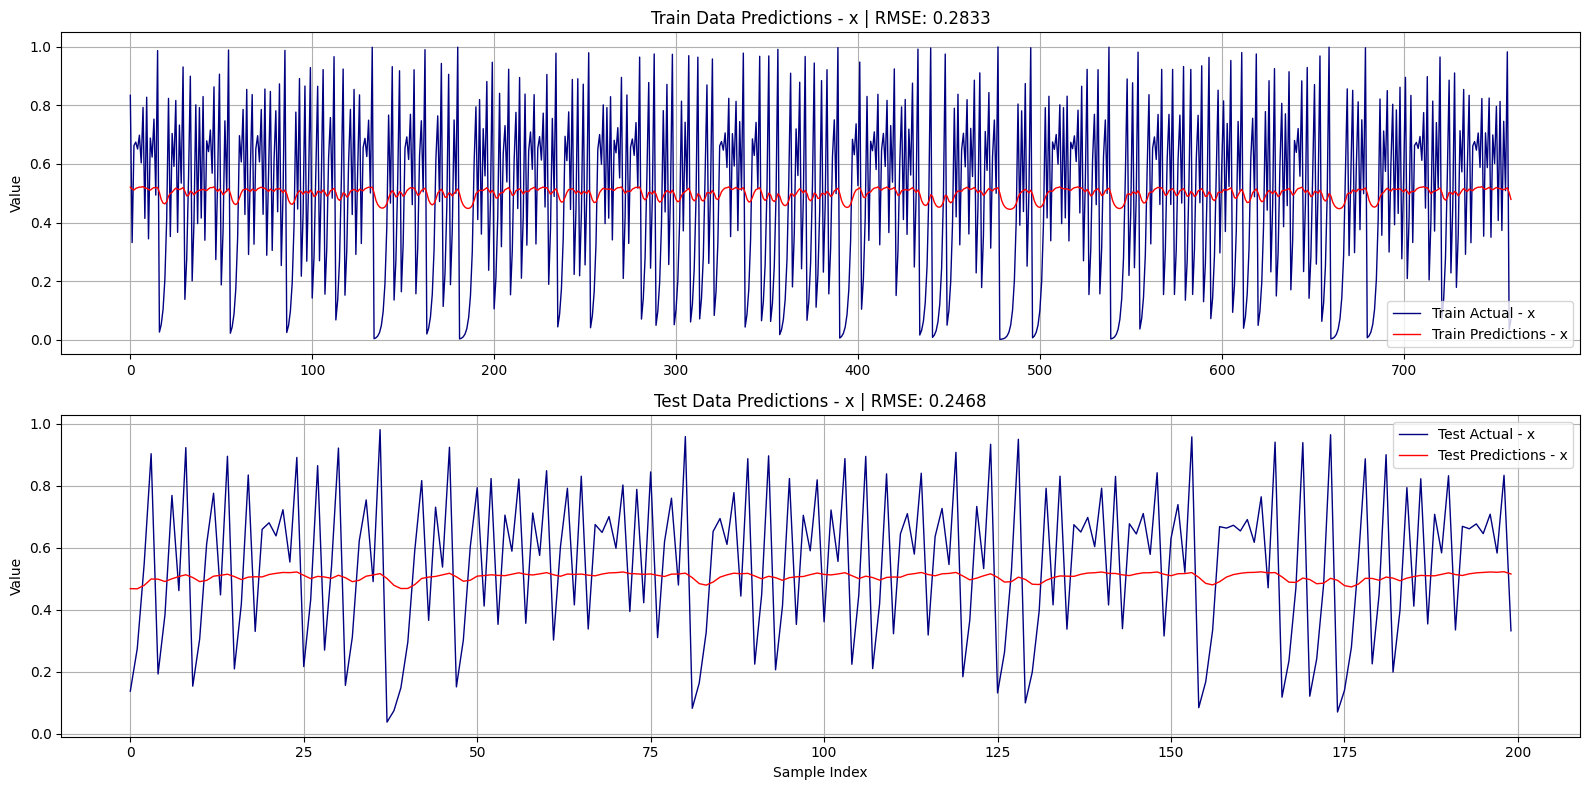

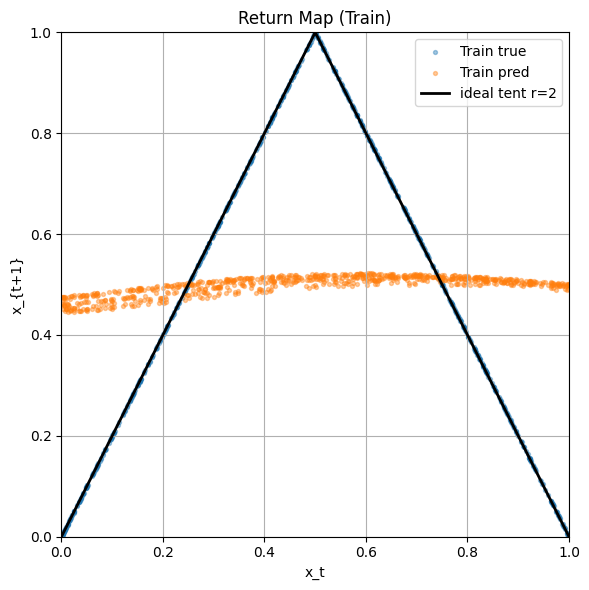

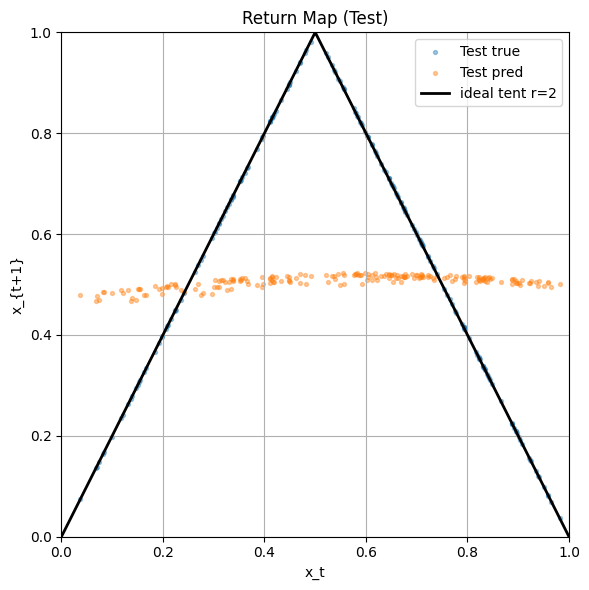

estimated_lyapunov: -0.017009490975955808


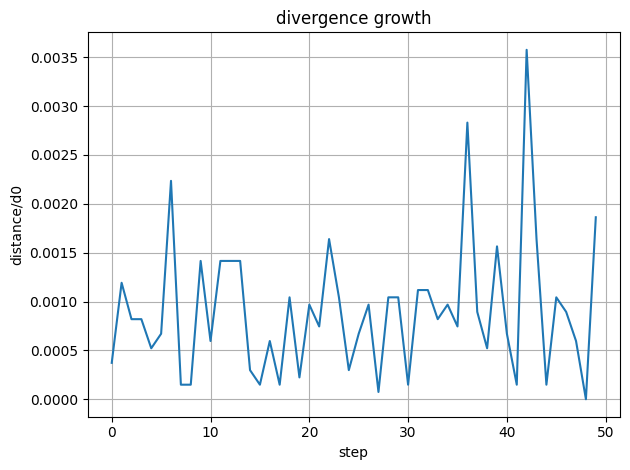


===== GRID SEARCH SUMMARY =====
   alpha  beta    n  seq_len  final_train_loss  final_test_loss  train_rmse  \
0    0.4   0.6  1.0       20          0.288672         0.202792    0.265799   
1   -0.3   1.3  1.0       20          0.330796         0.234482    0.288688   
2   -0.5   0.8  2.0       30          0.319314         0.210620    0.274909   
3    0.6   0.4  2.0       30          0.322112         0.228926    0.284493   
4   -0.2   0.9  3.0       40          0.280112         0.195026    0.259335   
5    0.7   0.7  3.0       40          0.325632         0.218902    0.283257   

   test_rmse  lyapunov  
0   0.237916 -0.197234  
1   0.255930 -0.263736  
2   0.242736 -0.050537  
3   0.252098 -0.269909  
4   0.232596 -0.106358  
5   0.246801 -0.017009  


In [7]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class ChebySigmoid(nn.Module):
    def __init__(self, alpha=1.0, beta=1.0, n=1.0):
        super().__init__()
        self.alpha = alpha
        self.beta = beta
        self.n = n
    def forward(self, x):
        s = torch.sigmoid(x)
        tb = torch.tanh(self.beta * x)
        tb = torch.clamp(tb, -1 + 1e-6, 1 - 1e-6)
        return s + self.alpha * torch.cos(self.n * torch.acos(tb)) * s * (1 - s)

class ChebyTanh(nn.Module):
    def __init__(self, alpha=1.0, beta=1.0, n=1.0):
        super().__init__()
        self.alpha = alpha
        self.beta = beta
        self.n = n
    def forward(self, x):
        tb = torch.tanh(self.beta * x)
        tb = torch.clamp(tb, -1 + 1e-6, 1 - 1e-6)
        t = torch.tanh(x)
        sech2 = (1 / torch.cosh(x)) ** 2
        return t + self.alpha * torch.cos(self.n * torch.acos(tb)) * sech2

class ChebyLSTMCell(nn.Module):
    def __init__(self, input_size, hidden_size, alpha=1.0, beta=1.0, n=1.0):
        super().__init__()
        self.hidden_size = hidden_size
        self.w_ih = nn.Parameter(torch.empty(4 * hidden_size, input_size))
        self.w_hh = nn.Parameter(torch.empty(4 * hidden_size, hidden_size))
        self.b_ih = nn.Parameter(torch.zeros(4 * hidden_size))
        self.b_hh = nn.Parameter(torch.zeros(4 * hidden_size))
        self.sig_act = ChebySigmoid(alpha, beta, n)
        self.tanh_act = ChebyTanh(alpha, beta, n)
        init.xavier_uniform_(self.w_ih)
        init.xavier_uniform_(self.w_hh)
    def forward(self, x_t, state):
        h, c = state
        gates = F.linear(x_t, self.w_ih, self.b_ih) + F.linear(h, self.w_hh, self.b_hh)
        i, f, g, o = gates.chunk(4, dim=1)
        i = self.sig_act(i)
        f = self.sig_act(f)
        g = self.tanh_act(g)
        o = self.sig_act(o)
        c_next = f * c + i * g
        h_next = o * self.tanh_act(c_next)
        return h_next, (h_next, c_next)

class ChebyLSTM(nn.Module):
    def __init__(self, hidden_size=32, alpha=1.0, beta=1.0, n=1.0):
        super().__init__()
        self.cell = ChebyLSTMCell(1, hidden_size, alpha, beta, n)
        self.fc = nn.Linear(hidden_size, 1)
        init.xavier_uniform_(self.fc.weight)
        if self.fc.bias is not None:
            init.constant_(self.fc.bias, 0)
    def forward(self, x):
        x = x.transpose(0,1)
        b = x.size(1)
        h = torch.zeros(b, self.cell.hidden_size, device=x.device)
        c = torch.zeros(b, self.cell.hidden_size, device=x.device)
        for t in range(x.size(0)):
            h, (h, c) = self.cell(x[t], (h,c))
        y = self.fc(h)
        return y

def load_series(csv_path, value_column="x"):
    df = pd.read_csv(csv_path)
    if value_column in df.columns:
        s = df[value_column]
    else:
        num_df = df.select_dtypes(include=[np.number])
        if num_df.shape[1] == 0:
            s = pd.to_numeric(df.iloc[:,0], errors='coerce')
        else:
            s = num_df.iloc[:,0]
    s = s.fillna(method='ffill').fillna(method='bfill')
    if s.isnull().any():
        s = s.fillna(s.mean())
    return s.to_numpy().astype(np.float32)

def make_supervised(series, seq_len):
    Xs = []
    Ys = []
    for i in range(len(series) - seq_len):
        Xs.append(series[i:i+seq_len])
        Ys.append(series[i+seq_len])
    X = np.array(Xs).reshape(-1, seq_len, 1)
    Y = np.array(Ys).reshape(-1, 1)
    return X, Y

def prepare_loaders(series, seq_len=20, split=0.8, batch=64):
    N = len(series)
    cut = int(N*split)
    scaler = MinMaxScaler(feature_range=(-1,1))
    scaler.fit(series[:cut].reshape(-1,1))
    scaled = scaler.transform(series.reshape(-1,1)).reshape(-1)
    X, Y = make_supervised(scaled, seq_len)
    Xtr, Xte = X[:cut-seq_len], X[cut-seq_len:]
    Ytr, Yte = Y[:cut-seq_len], Y[cut-seq_len:]
    Xtr = torch.tensor(Xtr, dtype=torch.float32, device=device)
    Ytr = torch.tensor(Ytr, dtype=torch.float32, device=device)
    Xte = torch.tensor(Xte, dtype=torch.float32, device=device)
    Yte = torch.tensor(Yte, dtype=torch.float32, device=device)
    train_loader = DataLoader(TensorDataset(Xtr,Ytr), batch_size=batch, shuffle=True)
    test_loader  = DataLoader(TensorDataset(Xte,Yte), batch_size=batch, shuffle=False)
    return train_loader, test_loader, scaler, Xtr, Ytr, Xte, Yte

def train_once(model, train_loader, test_loader, epochs=10, lr=1e-3):
    model = model.to(device)
    opt = optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()
    train_losses = []
    test_losses = []
    for ep in range(epochs):
        model.train()
        total = 0.0
        for xb, yb in train_loader:
            opt.zero_grad()
            yhat = model(xb)
            loss = loss_fn(yhat, yb)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
            opt.step()
            total += loss.item()
        avg_tr = total / max(1,len(train_loader))
        model.eval()
        tot_te = 0.0
        with torch.no_grad():
            for xb, yb in test_loader:
                yhat = model(xb)
                tot_te += loss_fn(yhat, yb).item()
        avg_te = tot_te / max(1,len(test_loader))
        train_losses.append(avg_tr)
        test_losses.append(avg_te)
        print(f"epoch {ep+1}: train {avg_tr:.5f}, test {avg_te:.5f}")
    return model, train_losses, test_losses

def inverse_and_rmse(model, X, Y, scaler):
    model.eval()
    with torch.no_grad():
        pred = model(X).cpu().numpy()
    true = Y.cpu().numpy()
    pred_inv = scaler.inverse_transform(pred)
    true_inv = scaler.inverse_transform(true)
    rmse = np.sqrt(np.mean((pred_inv-true_inv)**2))
    return true_inv.reshape(-1), pred_inv.reshape(-1), rmse

def full_series_from_scaler(series):
    return series

def plot_train_test_predictions(train_true, train_pred, train_rmse, test_true, test_pred, test_rmse, full_series):
    plt.figure(figsize=(16,4))
    plt.plot(full_series, color='black', linewidth=1)
    plt.title("Original Series (unscaled)")
    plt.xlabel("Time Index")
    plt.ylabel("Value")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    fig, ax = plt.subplots(2,1,figsize=(16,8),sharex=False)

    ax[0].plot(train_true, label='Train Actual - x', color='navy', linewidth=1)
    ax[0].plot(train_pred, label='Train Predictions - x', color='red', linewidth=1)
    ax[0].set_title(f"Train Data Predictions - x | RMSE: {train_rmse:.4f}")
    ax[0].set_ylabel("Value")
    ax[0].grid(True)
    ax[0].legend()

    ax[1].plot(test_true, label='Test Actual - x', color='navy', linewidth=1)
    ax[1].plot(test_pred, label='Test Predictions - x', color='red', linewidth=1)
    ax[1].set_title(f"Test Data Predictions - x | RMSE: {test_rmse:.4f}")
    ax[1].set_xlabel("Sample Index")
    ax[1].set_ylabel("Value")
    ax[1].grid(True)
    ax[1].legend()

    plt.tight_layout()
    plt.show()

def plot_return_map(x_last_train, y_train_true, y_train_pred, x_last_test, y_test_true, y_test_pred):
    xx = np.linspace(0,1,500)
    tent = np.where(xx<0.5, 2*xx, 2*(1-xx))

    plt.figure(figsize=(6,6))
    plt.scatter(x_last_train, y_train_true, s=8, alpha=0.4, label="Train true", color="tab:blue")
    plt.scatter(x_last_train, y_train_pred, s=8, alpha=0.4, label="Train pred", color="tab:orange")
    plt.plot(xx, tent, 'k-', lw=2, label="ideal tent r=2")
    plt.xlim(0,1); plt.ylim(0,1)
    plt.xlabel("x_t"); plt.ylabel("x_{t+1}")
    plt.title("Return Map (Train)")
    plt.grid(True); plt.legend(); plt.tight_layout()
    plt.show()

    plt.figure(figsize=(6,6))
    plt.scatter(x_last_test, y_test_true, s=8, alpha=0.4, label="Test true", color="tab:blue")
    plt.scatter(x_last_test, y_test_pred, s=8, alpha=0.4, label="Test pred", color="tab:orange")
    plt.plot(xx, tent, 'k-', lw=2, label="ideal tent r=2")
    plt.xlim(0,1); plt.ylim(0,1)
    plt.xlabel("x_t"); plt.ylabel("x_{t+1}")
    plt.title("Return Map (Test)")
    plt.grid(True); plt.legend(); plt.tight_layout()
    plt.show()

def lyapunov_estimate(model, series, scaler, seq_len=20, steps=50, eps=1e-4):
    model.eval()
    scaled_series = scaler.transform(series.reshape(-1,1)).reshape(-1)
    a = scaled_series[:seq_len].copy()
    b = scaled_series[:seq_len].copy()
    b[-1] += eps
    d0 = np.abs(b[-1]-a[-1])
    dists = []
    for _ in range(steps):
        A = torch.tensor(a.reshape(1,seq_len,1), dtype=torch.float32, device=device)
        B = torch.tensor(b.reshape(1,seq_len,1), dtype=torch.float32, device=device)
        with torch.no_grad():
            next_a = model(A).cpu().numpy().reshape(())
            next_b = model(B).cpu().numpy().reshape(())
        d = np.abs(next_b-next_a)
        dists.append(max(d,1e-12)/d0)
        a = np.concatenate([a[1:], [next_a]])
        b = np.concatenate([b[1:], [next_b]])
    logd = np.log(dists)
    t = np.arange(len(logd))
    num = np.sum((t-t.mean())*(logd-logd.mean()))
    den = np.sum((t-t.mean())**2)+1e-12
    slope = num/den
    return slope, dists

if __name__ == "__main__":
    csv_path = "tent_long.csv"
    if not os.path.exists(csv_path):
        print("csv not found, put tent1.csv next to this script")
        raise SystemExit(1)

    raw_series = load_series(csv_path, value_column="x")

    hyperparameter_sets = [
        {'alpha': 0.4,  'beta': 0.6,  'n': 1.0, 'seq_len': 20},
        {'alpha': -0.3, 'beta': 1.3,  'n': 1.0, 'seq_len': 20},
        {'alpha': -0.5, 'beta': 0.8,  'n': 2.0, 'seq_len': 30},
        {'alpha': 0.6,  'beta': 0.4,  'n': 2.0, 'seq_len': 30},
        {'alpha': -0.2, 'beta': 0.9,  'n': 3.0, 'seq_len': 40},
        {'alpha': 0.7,  'beta': 0.7,  'n': 3.0, 'seq_len': 40},
    ]

    summary_rows = []

    for hp in hyperparameter_sets:
        print("\n============================================")
        print("Now training with:", hp)

        seq_len = hp['seq_len']

        train_loader, test_loader, scaler, Xtr, Ytr, Xte, Yte = prepare_loaders(
            raw_series,
            seq_len=seq_len,
            split=0.8,
            batch=64
        )

        model = ChebyLSTM(
            hidden_size=32,
            alpha=hp['alpha'],
            beta=hp['beta'],
            n=hp['n']
        )

        model, train_losses, test_losses = train_once(
            model,
            train_loader,
            test_loader,
            epochs=10,
            lr=1e-3
        )

        train_true, train_pred, train_rmse = inverse_and_rmse(model, Xtr, Ytr, scaler)
        test_true,  test_pred,  test_rmse  = inverse_and_rmse(model, Xte, Yte, scaler)

        full_series = full_series_from_scaler(raw_series)

        x_last_train_scaled = Xtr[:,-1,:].detach().cpu().numpy()
        x_last_test_scaled  = Xte[:,-1,:].detach().cpu().numpy()
        x_last_train = scaler.inverse_transform(x_last_train_scaled).reshape(-1)
        x_last_test  = scaler.inverse_transform(x_last_test_scaled).reshape(-1)

        plot_train_test_predictions(
            train_true,
            train_pred,
            train_rmse,
            test_true,
            test_pred,
            test_rmse,
            full_series
        )

        plot_return_map(
            x_last_train,
            train_true,
            train_pred,
            x_last_test,
            test_true,
            test_pred
        )

        lyap, dist_curve = lyapunov_estimate(
            model,
            raw_series,
            scaler,
            seq_len=seq_len,
            steps=50,
            eps=1e-4
        )

        print("estimated_lyapunov:", lyap)

        plt.figure()
        plt.plot(dist_curve)
        plt.xlabel("step")
        plt.ylabel("distance/d0")
        plt.title("divergence growth")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        summary_rows.append({
            'alpha': hp['alpha'],
            'beta': hp['beta'],
            'n': hp['n'],
            'seq_len': seq_len,
            'final_train_loss': train_losses[-1],
            'final_test_loss': test_losses[-1],
            'train_rmse': train_rmse,
            'test_rmse': test_rmse,
            'lyapunov': lyap
        })

    print("\n===== GRID SEARCH SUMMARY =====")
    df_summary = pd.DataFrame(summary_rows)
    print(df_summary)
